In [ ]:
#weights = [0.1 1 1 1 1]
#gpu 4
# cell of checkpoints not included
# res_dir printbacth() changes --> test_images_1

In [ ]:
"""
good paper about losses:
https://arxiv.org/pdf/2006.14822.pdf

try freezing the encoder?? what does it mean? --> https://segmentation-models.readthedocs.io/en/latest/tutorial.html
transfer learning in encoder with tumor relared neural network
how to implement dropout
number of parameters in network
resnet34 or densenet121

TODOs:

check the activation of layers --> https://awjuliani.medium.com/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4
implement shuffling in the generator --> https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb // https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
"""

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import segmentation_models as sm

def get_model_with_dropout(base_model_name='efficientnetb4',activation='sigmoid',dropout = 0.1):
    base_model = sm.Unet(base_model_name, encoder_weights='imagenet')
    base_model_input = base_model.input
    base_model_output = base_model.get_layer('final_conv').output
    #add dropout
    base_model_output = keras.layers.Dropout(dropout)(base_model_output)
    #add activation
    output = keras.layers.Activation(activation, name=activation)(base_model_output)
    model_dp = keras.models.Model(base_model_input, output)

    return model_dp

Segmentation Models: using `tf.keras` framework.


In [2]:
import os
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#Run from server

gpu4 = "GPU-71b4cdfc-e381-0b98-9b24-4fc06284b496" 
gpu5 = "GPU-99d0769a-9f86-4800-a40e-2320dddcf5d1" 
gpu6 = "GPU-7423cfb5-cff4-ec4d-7e96-ea6e1591d56f"
gpu7 = "GPU-c0a8738f-6dd0-1b78-c38f-4969fd3886a8"

os.environ["CUDA_VISIBLE_DEVICES"]= gpu4
print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [5]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_DEPTH = 155

IMG_HEIGHT_UNET = 256
IMG_WIDTH_UNET = 256

N_IMG = 369
length_file = IMG_DEPTH * N_IMG
h5py_file_name = 'training.hdf5'
smooth = 1e-4

___

Generating the data and creating data arrays

In [ ]:
ImgDir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
features_path = list()
labels_path = list()
count = 0
lim = 10

for folder in os.listdir(ImgDir):
    count +=1
    if 'Training' in folder:
        new_dir = os.path.join(ImgDir,folder)
        data = os.listdir(new_dir)
        for files in data:
            if 'flair' in files:
                features_path.append(os.path.join(new_dir, files))
            if 'seg' in files:
                labels_path.append(os.path.join(new_dir, files))

print(len(features_path))
print(len(labels_path))


In [ ]:
img_conc_features = np.zeros((len(features_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = features_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_features[i,:,:,:] = imgarr
    
img_conc_features = np.concatenate(img_conc_features,axis=2)
print(np.shape(img_conc_features))

In [ ]:
img_conc_labels = np.zeros((len(labels_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = labels_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_labels[i,:,:,:] = imgarr
    
img_conc_labels = np.concatenate(img_conc_labels,axis=2)
print(np.shape(img_conc_labels))

In [ ]:
with h5py.File(os.path.join('..','data',h5py_file_name), 'a') as f:
    f.create_dataset("features", data=img_conc_features, compression="gzip")
    f.create_dataset("labels", data=img_conc_labels, compression="gzip")

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["features"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["labels"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

___

Load data and model

In [6]:
train_stop = 20001
n_images = 25000

# n_images = 57195
# train_stop = int(np.floor(n_images * 0.9))

# images = X_nib.get_fdata()
# labels = y_nib.get_fdata()

#https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

#tf.debugging.set_log_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=["/device:GPU:0", "/device:GPU:1"])
# with strategy.scope():

#with tf.device("/device:GPU:0"):    

with h5py.File(os.path.join('..','data',h5py_file_name), "r") as f:
    #images_train = f["features"][()] #the whole dataset: 57195 images
    #labels_train = f["labels"][()]

    images = f["features"]
    images_train = tf.constant(images[:,:,:train_stop],dtype=tf.float32) #taking a subsample
    images_val = tf.constant(images[:,:,train_stop:n_images+1],dtype=tf.float32)

    labels = f["labels"]
    labels_train = tf.constant(labels[:,:,:train_stop],dtype=tf.float32)
    labels_val = tf.constant(images[:,:,train_stop:n_images+1],dtype=tf.float32)

#batch_size = 30 

print(labels_val[:,:,1])

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(240, 240), dtype=float32)


In [7]:
np.shape(images_train)

TensorShape([240, 240, 20001])

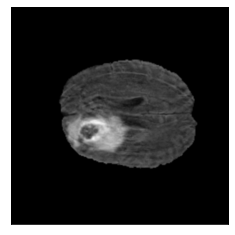

In [8]:
plt.imshow(images_train[:,:,96], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

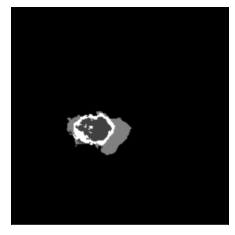

In [9]:
plt.imshow(labels_train[:,:,100], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

____

In [10]:
import segmentation_models as sm

BACKBONE = 'resnet34' #'densenet121' 
CLASSES = ['0','1','2','3','4']
LR = 0.0001
EPOCHS = 70
n_classes = 5
BATCH_SIZE = 30
decoder_filters = (128, 64, 32, 16, 8)   #standard:(256, 128, 64, 32, 16)

In [11]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def visualize_histories(**images):
    """Import as tuples: one = (a,b)"""
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.ylim(0,1)
        plt.xlabel('epoch')
        if i == 0:
            plt.ylabel('dice_score')
        plt.title(' '.join(name.split('_')).title())
        plt.plot(np.asarray(image[0]))
        plt.plot(np.asarray(image[1]))
        plt.legend(['train', 'val'])
    plt.show()

In [12]:
class Dataset:
    
    CLASSES = ['0','1','2','3','4']
    
    def __init__(self, images_train, images_label, classes = None):
        self.images_fps = images_train
        self.masks_fps = images_label
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.ids = len(images_train[1,1,:])
    
    def __getitem__(self, i):

        X_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)

        X_new[:IMG_HEIGHT,:IMG_WIDTH,0] = self.images_fps[:,:,i]
        X_new[:IMG_HEIGHT,:IMG_WIDTH,1] = self.images_fps[:,:,i]
        X_new[:IMG_HEIGHT,:IMG_WIDTH,2] = self.images_fps[:,:,i]
        
        y_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET), np.float32)

        image = X_new[:,:,:]
        
        y_new[:IMG_HEIGHT,:IMG_WIDTH] = self.masks_fps[:,:,i]
        
        mask = y_new
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
#         if mask.shape[-1] != 1:
#             background = 1 - mask.sum(axis=-1, keepdims=True)
#             mask = np.concatenate((mask, background), axis=-1)
        
        return image, mask
    
    def __len__(self):
        return self.ids

In [13]:
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=BATCH_SIZE, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
            
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return (batch[0],batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

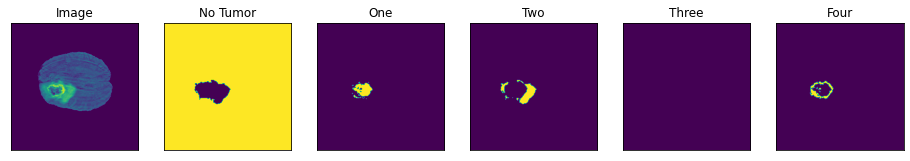

In [14]:
dataset = Dataset(images_train, labels_train, classes=['0','1','2','3','4'])
image, mask = dataset[100]
visualize(
    image=image[:,:,0], ### if putting the whole image, black and white, could it be the reason of the problem??
    no_tumor=mask[..., 0].squeeze(),
    one=mask[..., 1].squeeze(),
    two=mask[..., 2].squeeze(),
    three=mask[..., 3].squeeze(),
    four=mask[..., 4].squeeze()
)

In [15]:
#image = np.expand_dims(image, axis=0)
np.shape(image[np.newaxis, ...])

(1, 256, 256, 3)

In [16]:
np.shape(mask)

(256, 256, 5)

In [17]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
# n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, decoder_filters = decoder_filters)
#encoder weights from ImageNet, not pretty realted to tumors, so i delete it, interesting to add other weights

In [18]:
#tf.debugging.set_log_device_placement(False)

In [19]:
def _gather_channels(x, indexes, **kwargs):
    """Slice tensor along channels axis by given indexes"""
    backend = K
    if backend.image_data_format() == 'channels_last':
        x = backend.permute_dimensions(x, (3, 0, 1, 2))
        x = backend.gather(x, indexes)
        x = backend.permute_dimensions(x, (1, 2, 3, 0))
    else:
        x = backend.permute_dimensions(x, (1, 0, 2, 3))
        x = backend.gather(x, indexes)
        x = backend.permute_dimensions(x, (1, 0, 2, 3))
    return x

def get_reduce_axes(per_image, **kwargs):
    backend = K
    axes = [1, 2] if backend.image_data_format() == 'channels_last' else [2, 3]
    if not per_image:
        axes.insert(0, 0)
    return axes

def gather_channels(*xs, indexes=None, **kwargs):
    """Slice tensors along channels axis by given indexes"""
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes, **kwargs) for x in xs]
    return xs

def average(x, per_image=False, class_weights=None, **kwargs):
    backend = K
    if per_image:
        x = backend.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return backend.mean(x)

def round_if_needed(x, threshold, **kwargs):
    backend = K
    if threshold is not None:
        x = backend.greater(x, threshold)
        x = backend.cast(x, backend.floatx())
    return x

def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=smooth, per_image=False, threshold=None, **kwargs):
    backend = K
    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    intersection = backend.sum(gt * pr, axis=axes)
    union = backend.sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    print(score)
    score = average(score, per_image, class_weights, **kwargs)

    return score

metrics_test = [iou_score]

In [20]:
from sklearn.metrics import make_scorer

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    mask0 = y_pred[...,0]
    mask1 = y_pred[...,1]
    mask2 = y_pred[...,2]
    mask3 = y_pred[...,3]
    mask4 = y_pred[...,4]
    
    print(mask4)
    
    masks = [mask0, mask1, mask2, mask3, mask4]
    
    true0 = y_true[...,0]
    true1 = y_true[...,1]
    true2 = y_true[...,2]
    true3 = y_true[...,3]
    true4 = y_true[...,4]
    
    print(true4)
    
    trues = [true0, true1, true2, true3, true4]
    
    intersection = []
    
    for i in range(5):
        intersection.append(K.sum(trues[i] * masks[i]))
    
    intersection_test = np.asarray(intersection)
    coef_test = (2. * intersection_test + smooth) / (intersection_test + masks + smooth)
    
    intersection = K.sum(y_true_f * y_pred_f)
    coef =  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    
    return coef

score = make_scorer(dice_coef, greater_is_better=True)

metrics_test2 = [dice_coef]

In [21]:
def dice_metric(ground_truth, prediction):

    #for metrics, it's good to round predictions:
    prediction = K.round(prediction)

    #intersection and totals per class per batch (considers channels last)
    intersection = ground_truth * prediction
    print(np.shape(intersection))
    intersection = K.sum(intersection, axis=[1,2])
    ground_truth = K.sum(ground_truth, axis=[1,2])
    prediction = K.sum(prediction, axis=[1,2])

    dice = ((2 * intersection) + K.epsilon()) / (ground_truth + prediction + K.epsilon())
    
metrics_test3 = [dice_metric]

In [22]:
#calculates dice considering an input with a single class
def dice_single(true,pred):
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + K.epsilon()) / (true + pred + K.epsilon())

def dice_for_class(index):
    def dice_inner(true,pred):

        #get only the desired class
        true = true[:,:,:,index]
        pred = pred[:,:,:,index]

        #return dice per class
        return dice_single(true,pred)
    return dice_inner

metrics_test4 = [dice_for_class(i) for i in range(5)]

In [23]:
#calculates dice considering an input with a single class
def dice_single(true,pred):
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + K.epsilon()) / (true + pred + K.epsilon())

def dice_inner_0(true,pred,index=0):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_1(true,pred,index=1):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_2(true,pred,index=2):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_3(true,pred,index=3):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_4(true,pred,index=4):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

metrics_test5 = [dice_inner_0, dice_inner_1, dice_inner_2, dice_inner_3, dice_inner_4, sm.metrics.FScore(threshold=0.5)]

In [24]:
# define optomizer

    
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1, 5, 3, 1, 1])) 
# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

total_loss = sm.losses.DiceLoss(class_weights=np.array([0.1, 1, 1, 1, 1])) 

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [25]:
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics_test5)

In [26]:
# Dataset for train images


#strategy = tf.distribute.MirroredStrategy(devices=["/device:GPU:0", "/device:GPU:1"])
#with strategy.scope():

        train_dataset = Dataset(
            images_train, 
            labels_train, 
            classes=CLASSES
        )

        # Dataset for validation images
        valid_dataset = Dataset(
            images_val, 
            labels_val, 
            classes=CLASSES
        )

        train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
        valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # check shapes for errors
        assert train_dataloader[0][0].shape == (BATCH_SIZE, IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3)
        assert train_dataloader[0][1].shape == (BATCH_SIZE, IMG_HEIGHT_UNET, IMG_WIDTH_UNET, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
#     tf.keras.callbacks.ReduceLROnPlateau(),
# ]

# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(),
# ]

In [27]:
train_dataloader[0][1].shape

(30, 256, 256, 5)

In [28]:
class printbatch(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, epoch, logs={}):

        res_dir = os.path.join("..","data","test_images_1")

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

    
    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        
        res_dir = os.path.join("..","data","test_images_1")
    
        x_img = os.path.join(res_dir,"X_input.jpg")
        y_img = os.path.join(res_dir,"Y_truth.jpg")
        predicted_img = os.path.join(res_dir,f"{epoch}_Y_predicted.jpg")
        
        image, gt_mask = train_dataset[100]
        #image = np.expand_dims(image, axis=0)
        pr_mask = self.model.predict(image[np.newaxis, ...])
    
        gt_mask_vis = gt_mask[...,0:3]
        pr_mask_vis = pr_mask[...,0:3]

#         visualize(
#             image=denormalize(image.squeeze()),
#             gt_mask_vis=gt_mask_vis.squeeze(),
#             pr_mask_vis=pr_mask_vis.squeeze(),
#         )

        cv2.imwrite(x_img, image[:,:,0])
        cv2.imwrite(y_img, gt_mask_vis.squeeze())
        cv2.imwrite(predicted_img, pr_mask_vis.squeeze())
#         cv2.imwrite(predicted_img, prediction[0,:,:,:] * 255.)
        
        
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

pb = printbatch()        

In [29]:
# checkpoint_path =  os.path.join("..","data","checkpoints","training_2/cp-{epoch:04d}.ckpt")
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights every 5 epochs
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     save_weights_only=True,
#     save_freq=5*BATCH_SIZE)


# callbacks = [pb, cp_callback]
callbacks =[pb]

In [ ]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS,
    verbose = 0,
    callbacks = callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
)

Instructions for updating:
Please use Model.fit, which supports generators.
../data/test_images_1 directory already exist
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inne

...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 43; got log keys: []
...Training: end of batch 43; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 44; got log keys: []
...Training: end of batch 44; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 45; got log keys: []
...Training: end of batch 45; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 46; got log keys: []
...Training: end of batch 46; 

...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 86; got log keys: []
...Training: end of batch 86; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 87; got log keys: []
...Training: end of batch 87; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 88; got log keys: []
...Training: end of batch 88; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 89; got log keys: []
...Training: end of batch 89; 

...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of batch 127; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 128; got log keys: []
...Training: end of batch 128; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 129; got log keys: []
...Training: end of batch 129; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 130; got log keys: []
...Training: end of batch 130; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 131; got log keys: []
...Training: end of 

...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of batch 169; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 170; got log keys: []
...Training: end of batch 170; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 171; got log keys: []
...Training: end of batch 171; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 172; got log keys: []
...Training: end of batch 172; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 173; got log keys: []
...Training: end of 

...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of batch 211; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 212; got log keys: []
...Training: end of batch 212; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 213; got log keys: []
...Training: end of batch 213; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 214; got log keys: []
...Training: end of batch 214; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 215; got log keys: []
...Training: end of 

...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of batch 253; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 254; got log keys: []
...Training: end of batch 254; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 255; got log keys: []
...Training: end of batch 255; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 256; got log keys: []
...Training: end of batch 256; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 257; got log keys: []
...Training: end of 

...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of batch 295; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 296; got log keys: []
...Training: end of batch 296; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 297; got log keys: []
...Training: end of batch 297; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 298; got log keys: []
...Training: end of batch 298; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 299; got log keys: []
...Training: end of 

...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of batch 337; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 338; got log keys: []
...Training: end of batch 338; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 339; got log keys: []
...Training: end of batch 339; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 340; got log keys: []
...Training: end of batch 340; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 341; got log keys: []
...Training: end of 

...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of batch 379; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 380; got log keys: []
...Training: end of batch 380; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 381; got log keys: []
...Training: end of batch 381; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 382; got log keys: []
...Training: end of batch 382; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 383; got log keys: []
...Training: end of 

...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of batch 421; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 422; got log keys: []
...Training: end of batch 422; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 423; got log keys: []
...Training: end of batch 423; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 424; got log keys: []
...Training: end of batch 424; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 425; got log keys: []
...Training: end of 

...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of batch 463; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 464; got log keys: []
...Training: end of batch 464; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 465; got log keys: []
...Training: end of batch 465; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 466; got log keys: []
...Training: end of batch 466; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 467; got log keys: []
...Training: end of 

...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of batch 505; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 506; got log keys: []
...Training: end of batch 506; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 507; got log keys: []
...Training: end of batch 507; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 508; got log keys: []
...Training: end of batch 508; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 509; got log keys: []
...Training: end of 

...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of batch 547; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 548; got log keys: []
...Training: end of batch 548; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 549; got log keys: []
...Training: end of batch 549; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 550; got log keys: []
...Training: end of batch 550; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 551; got log keys: []
...Training: end of 

...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of batch 589; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 590; got log keys: []
...Training: end of batch 590; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 591; got log keys: []
...Training: end of batch 591; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 592; got log keys: []
...Training: end of batch 592; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 593; got log keys: []
...Training: end of 

...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of batch 631; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 632; got log keys: []
...Training: end of batch 632; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 633; got log keys: []
...Training: end of batch 633; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 634; got log keys: []
...Training: end of batch 634; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 635; got log keys: []
...Training: end of 

...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 8; got log keys: []
...Training: end of batch 8; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 9; got log keys: []
...Training: end of batch 9; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 10; got log keys: []
...Training: end of batch 10; got log k

...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 50; got log keys: []
...Training: end of batch 50; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 51; got log keys: []
...Training: end of batch 51; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 52; got log keys: []
...Training: end of batch 52; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 53; got log keys: []
...Training: end of batch 53; 

...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 93; got log keys: []
...Training: end of batch 93; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 94; got log keys: []
...Training: end of batch 94; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 95; got log keys: []
...Training: end of batch 95; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 96; got log keys: []
...Training: end of batch 96; 

...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of batch 134; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 135; got log keys: []
...Training: end of batch 135; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 136; got log keys: []
...Training: end of batch 136; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 137; got log keys: []
...Training: end of batch 137; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 138; got log keys: []
...Training: end of 

...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of batch 176; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 177; got log keys: []
...Training: end of batch 177; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 178; got log keys: []
...Training: end of batch 178; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 179; got log keys: []
...Training: end of batch 179; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 180; got log keys: []
...Training: end of 

...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of batch 218; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 219; got log keys: []
...Training: end of batch 219; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 220; got log keys: []
...Training: end of batch 220; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 221; got log keys: []
...Training: end of batch 221; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 222; got log keys: []
...Training: end of 

...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of batch 260; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 261; got log keys: []
...Training: end of batch 261; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 262; got log keys: []
...Training: end of batch 262; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 263; got log keys: []
...Training: end of batch 263; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 264; got log keys: []
...Training: end of 

...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of batch 302; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 303; got log keys: []
...Training: end of batch 303; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 304; got log keys: []
...Training: end of batch 304; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 305; got log keys: []
...Training: end of batch 305; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 306; got log keys: []
...Training: end of 

...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of batch 344; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 345; got log keys: []
...Training: end of batch 345; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 346; got log keys: []
...Training: end of batch 346; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 347; got log keys: []
...Training: end of batch 347; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 348; got log keys: []
...Training: end of 

...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of batch 386; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 387; got log keys: []
...Training: end of batch 387; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 388; got log keys: []
...Training: end of batch 388; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 389; got log keys: []
...Training: end of batch 389; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 390; got log keys: []
...Training: end of 

...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of batch 428; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 429; got log keys: []
...Training: end of batch 429; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 430; got log keys: []
...Training: end of batch 430; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 431; got log keys: []
...Training: end of batch 431; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 432; got log keys: []
...Training: end of 

...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of batch 470; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 471; got log keys: []
...Training: end of batch 471; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 472; got log keys: []
...Training: end of batch 472; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 473; got log keys: []
...Training: end of batch 473; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 474; got log keys: []
...Training: end of 

...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of batch 512; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 513; got log keys: []
...Training: end of batch 513; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 514; got log keys: []
...Training: end of batch 514; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 515; got log keys: []
...Training: end of batch 515; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 516; got log keys: []
...Training: end of 

...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of batch 554; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 555; got log keys: []
...Training: end of batch 555; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 556; got log keys: []
...Training: end of batch 556; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 557; got log keys: []
...Training: end of batch 557; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 558; got log keys: []
...Training: end of 

...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of batch 596; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 597; got log keys: []
...Training: end of batch 597; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 598; got log keys: []
...Training: end of batch 598; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 599; got log keys: []
...Training: end of batch 599; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 600; got log keys: []
...Training: end of 

...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of batch 638; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 639; got log keys: []
...Training: end of batch 639; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 640; got log keys: []
...Training: end of batch 640; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 641; got log keys: []
...Training: end of batch 641; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 642; got log keys: []
...Training: end of 

...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 14; got log keys: []
...Training: end of batch 14; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 15; got log keys: []
...Training: end of batch 15; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 16; got log keys: []
...Training: end of batch 16; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 17; got log keys: []
...Training: end of batch 17; 

...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 57; got log keys: []
...Training: end of batch 57; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 58; got log keys: []
...Training: end of batch 58; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 59; got log keys: []
...Training: end of batch 59; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 60; got log keys: []
...Training: end of batch 60; 

...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 100; got log keys: []
...Training: end of batch 100; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 101; got log keys: []
...Training: end of batch 101; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 102; got log keys: []
...Training: end of batch 102; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 103; got log keys: []
...Training: end of bat

...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of batch 141; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 142; got log keys: []
...Training: end of batch 142; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 143; got log keys: []
...Training: end of batch 143; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 144; got log keys: []
...Training: end of batch 144; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 145; got log keys: []
...Training: end of 

...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of batch 183; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 184; got log keys: []
...Training: end of batch 184; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 185; got log keys: []
...Training: end of batch 185; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 186; got log keys: []
...Training: end of batch 186; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 187; got log keys: []
...Training: end of 

...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of batch 225; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 226; got log keys: []
...Training: end of batch 226; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 227; got log keys: []
...Training: end of batch 227; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 228; got log keys: []
...Training: end of batch 228; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 229; got log keys: []
...Training: end of 

...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of batch 267; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 268; got log keys: []
...Training: end of batch 268; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 269; got log keys: []
...Training: end of batch 269; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 270; got log keys: []
...Training: end of batch 270; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 271; got log keys: []
...Training: end of 

...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of batch 309; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 310; got log keys: []
...Training: end of batch 310; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 311; got log keys: []
...Training: end of batch 311; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 312; got log keys: []
...Training: end of batch 312; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 313; got log keys: []
...Training: end of 

...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of batch 351; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 352; got log keys: []
...Training: end of batch 352; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 353; got log keys: []
...Training: end of batch 353; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 354; got log keys: []
...Training: end of batch 354; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 355; got log keys: []
...Training: end of 

...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of batch 393; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 394; got log keys: []
...Training: end of batch 394; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 395; got log keys: []
...Training: end of batch 395; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 396; got log keys: []
...Training: end of batch 396; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 397; got log keys: []
...Training: end of 

...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of batch 435; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 436; got log keys: []
...Training: end of batch 436; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 437; got log keys: []
...Training: end of batch 437; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 438; got log keys: []
...Training: end of batch 438; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 439; got log keys: []
...Training: end of 

...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of batch 477; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 478; got log keys: []
...Training: end of batch 478; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 479; got log keys: []
...Training: end of batch 479; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 480; got log keys: []
...Training: end of batch 480; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 481; got log keys: []
...Training: end of 

...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of batch 519; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 520; got log keys: []
...Training: end of batch 520; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 521; got log keys: []
...Training: end of batch 521; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 522; got log keys: []
...Training: end of batch 522; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 523; got log keys: []
...Training: end of 

...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of batch 561; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 562; got log keys: []
...Training: end of batch 562; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 563; got log keys: []
...Training: end of batch 563; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 564; got log keys: []
...Training: end of batch 564; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 565; got log keys: []
...Training: end of 

...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of batch 603; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 604; got log keys: []
...Training: end of batch 604; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 605; got log keys: []
...Training: end of batch 605; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 606; got log keys: []
...Training: end of batch 606; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 607; got log keys: []
...Training: end of 

...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of batch 645; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 646; got log keys: []
...Training: end of batch 646; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 647; got log keys: []
...Training: end of batch 647; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 648; got log keys: []
...Training: end of batch 648; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 649; got log keys: []
...Training: end of 

...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 21; got log keys: []
...Training: end of batch 21; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 22; got log keys: []
...Training: end of batch 22; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 23; got log keys: []
...Training: end of batch 23; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 24; got log keys: []
...Training: end of batch 24; 

...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 64; got log keys: []
...Training: end of batch 64; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 65; got log keys: []
...Training: end of batch 65; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 66; got log keys: []
...Training: end of batch 66; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 67; got log keys: []
...Training: end of batch 67; 

...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of batch 106; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 107; got log keys: []
...Training: end of batch 107; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 108; got log keys: []
...Training: end of batch 108; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 109; got log keys: []
...Training: end of batch 109; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 110; got log keys: []
...Training: end of 

...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of batch 148; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 149; got log keys: []
...Training: end of batch 149; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 150; got log keys: []
...Training: end of batch 150; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 151; got log keys: []
...Training: end of batch 151; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 152; got log keys: []
...Training: end of 

...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of batch 190; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 191; got log keys: []
...Training: end of batch 191; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 192; got log keys: []
...Training: end of batch 192; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 193; got log keys: []
...Training: end of batch 193; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 194; got log keys: []
...Training: end of 

...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of batch 232; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 233; got log keys: []
...Training: end of batch 233; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 234; got log keys: []
...Training: end of batch 234; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 235; got log keys: []
...Training: end of batch 235; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 236; got log keys: []
...Training: end of 

...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of batch 274; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 275; got log keys: []
...Training: end of batch 275; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 276; got log keys: []
...Training: end of batch 276; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 277; got log keys: []
...Training: end of batch 277; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 278; got log keys: []
...Training: end of 

...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of batch 316; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 317; got log keys: []
...Training: end of batch 317; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 318; got log keys: []
...Training: end of batch 318; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 319; got log keys: []
...Training: end of batch 319; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 320; got log keys: []
...Training: end of 

...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of batch 358; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 359; got log keys: []
...Training: end of batch 359; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 360; got log keys: []
...Training: end of batch 360; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 361; got log keys: []
...Training: end of batch 361; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 362; got log keys: []
...Training: end of 

...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of batch 400; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 401; got log keys: []
...Training: end of batch 401; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 402; got log keys: []
...Training: end of batch 402; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 403; got log keys: []
...Training: end of batch 403; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 404; got log keys: []
...Training: end of 

...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of batch 442; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 443; got log keys: []
...Training: end of batch 443; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 444; got log keys: []
...Training: end of batch 444; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 445; got log keys: []
...Training: end of batch 445; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 446; got log keys: []
...Training: end of 

...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of batch 484; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 485; got log keys: []
...Training: end of batch 485; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 486; got log keys: []
...Training: end of batch 486; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 487; got log keys: []
...Training: end of batch 487; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 488; got log keys: []
...Training: end of 

...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of batch 526; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 527; got log keys: []
...Training: end of batch 527; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 528; got log keys: []
...Training: end of batch 528; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 529; got log keys: []
...Training: end of batch 529; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 530; got log keys: []
...Training: end of 

...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of batch 568; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 569; got log keys: []
...Training: end of batch 569; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 570; got log keys: []
...Training: end of batch 570; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 571; got log keys: []
...Training: end of batch 571; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 572; got log keys: []
...Training: end of 

...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of batch 610; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 611; got log keys: []
...Training: end of batch 611; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 612; got log keys: []
...Training: end of batch 612; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 613; got log keys: []
...Training: end of batch 613; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 614; got log keys: []
...Training: end of 

...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of batch 652; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 653; got log keys: []
...Training: end of batch 653; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 654; got log keys: []
...Training: end of batch 654; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 655; got log keys: []
...Training: end of batch 655; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 656; got log keys: []
...Training: end of 

...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 28; got log keys: []
...Training: end of batch 28; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 29; got log keys: []
...Training: end of batch 29; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 30; got log keys: []
...Training: end of batch 30; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 31; got log keys: []
...Training: end of batch 31; 

...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 71; got log keys: []
...Training: end of batch 71; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 72; got log keys: []
...Training: end of batch 72; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 73; got log keys: []
...Training: end of batch 73; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 74; got log keys: []
...Training: end of batch 74; 

...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of batch 113; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 114; got log keys: []
...Training: end of batch 114; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 115; got log keys: []
...Training: end of batch 115; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 116; got log keys: []
...Training: end of batch 116; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 117; got log keys: []
...Training: end of 

...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of batch 155; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 156; got log keys: []
...Training: end of batch 156; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 157; got log keys: []
...Training: end of batch 157; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 158; got log keys: []
...Training: end of batch 158; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 159; got log keys: []
...Training: end of 

...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of batch 197; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 198; got log keys: []
...Training: end of batch 198; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 199; got log keys: []
...Training: end of batch 199; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 200; got log keys: []
...Training: end of batch 200; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 201; got log keys: []
...Training: end of 

...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of batch 239; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 240; got log keys: []
...Training: end of batch 240; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 241; got log keys: []
...Training: end of batch 241; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 242; got log keys: []
...Training: end of batch 242; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 243; got log keys: []
...Training: end of 

...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of batch 281; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 282; got log keys: []
...Training: end of batch 282; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 283; got log keys: []
...Training: end of batch 283; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 284; got log keys: []
...Training: end of batch 284; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 285; got log keys: []
...Training: end of 

...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of batch 323; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 324; got log keys: []
...Training: end of batch 324; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 325; got log keys: []
...Training: end of batch 325; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 326; got log keys: []
...Training: end of batch 326; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 327; got log keys: []
...Training: end of 

...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of batch 365; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 366; got log keys: []
...Training: end of batch 366; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 367; got log keys: []
...Training: end of batch 367; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 368; got log keys: []
...Training: end of batch 368; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 369; got log keys: []
...Training: end of 

...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of batch 407; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 408; got log keys: []
...Training: end of batch 408; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 409; got log keys: []
...Training: end of batch 409; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 410; got log keys: []
...Training: end of batch 410; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 411; got log keys: []
...Training: end of 

...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of batch 449; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 450; got log keys: []
...Training: end of batch 450; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 451; got log keys: []
...Training: end of batch 451; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 452; got log keys: []
...Training: end of batch 452; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 453; got log keys: []
...Training: end of 

...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of batch 491; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 492; got log keys: []
...Training: end of batch 492; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 493; got log keys: []
...Training: end of batch 493; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 494; got log keys: []
...Training: end of batch 494; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 495; got log keys: []
...Training: end of 

...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of batch 533; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 534; got log keys: []
...Training: end of batch 534; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 535; got log keys: []
...Training: end of batch 535; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 536; got log keys: []
...Training: end of batch 536; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 537; got log keys: []
...Training: end of 

...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of batch 575; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 576; got log keys: []
...Training: end of batch 576; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 577; got log keys: []
...Training: end of batch 577; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 578; got log keys: []
...Training: end of batch 578; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 579; got log keys: []
...Training: end of 

...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of batch 617; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 618; got log keys: []
...Training: end of batch 618; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 619; got log keys: []
...Training: end of batch 619; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 620; got log keys: []
...Training: end of batch 620; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 621; got log keys: []
...Training: end of 

...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of batch 659; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 660; got log keys: []
...Training: end of batch 660; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 661; got log keys: []
...Training: end of batch 661; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 662; got log keys: []
...Training: end of batch 662; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 663; got log keys: []
...Training: end of 

...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 35; got log keys: []
...Training: end of batch 35; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 36; got log keys: []
...Training: end of batch 36; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 37; got log keys: []
...Training: end of batch 37; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 38; got log keys: []
...Training: end of batch 38; 

...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 78; got log keys: []
...Training: end of batch 78; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 79; got log keys: []
...Training: end of batch 79; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 80; got log keys: []
...Training: end of batch 80; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 81; got log keys: []
...Training: end of batch 81; 

...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of batch 120; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 121; got log keys: []
...Training: end of batch 121; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 122; got log keys: []
...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of batch 123; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 124; got log keys: []
...Training: end of 

...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of batch 162; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 163; got log keys: []
...Training: end of batch 163; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 164; got log keys: []
...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of batch 165; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 166; got log keys: []
...Training: end of 

...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of batch 204; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 205; got log keys: []
...Training: end of batch 205; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 206; got log keys: []
...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of batch 207; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 208; got log keys: []
...Training: end of 

...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of batch 246; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 247; got log keys: []
...Training: end of batch 247; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 248; got log keys: []
...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of batch 249; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 250; got log keys: []
...Training: end of 

...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of batch 288; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 289; got log keys: []
...Training: end of batch 289; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 290; got log keys: []
...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of batch 291; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 292; got log keys: []
...Training: end of 

...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of batch 330; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 331; got log keys: []
...Training: end of batch 331; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 332; got log keys: []
...Training: end of batch 332; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 333; got log keys: []
...Training: end of batch 333; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 334; got log keys: []
...Training: end of 

...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of batch 372; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 373; got log keys: []
...Training: end of batch 373; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 374; got log keys: []
...Training: end of batch 374; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 375; got log keys: []
...Training: end of batch 375; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 376; got log keys: []
...Training: end of 

...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of batch 414; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 415; got log keys: []
...Training: end of batch 415; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 416; got log keys: []
...Training: end of batch 416; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 417; got log keys: []
...Training: end of batch 417; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 418; got log keys: []
...Training: end of 

...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of batch 456; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 457; got log keys: []
...Training: end of batch 457; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 458; got log keys: []
...Training: end of batch 458; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 459; got log keys: []
...Training: end of batch 459; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 460; got log keys: []
...Training: end of 

...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of batch 498; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 499; got log keys: []
...Training: end of batch 499; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 500; got log keys: []
...Training: end of batch 500; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 501; got log keys: []
...Training: end of batch 501; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 502; got log keys: []
...Training: end of 

...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of batch 540; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 541; got log keys: []
...Training: end of batch 541; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 542; got log keys: []
...Training: end of batch 542; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 543; got log keys: []
...Training: end of batch 543; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 544; got log keys: []
...Training: end of 

...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of batch 582; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 583; got log keys: []
...Training: end of batch 583; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 584; got log keys: []
...Training: end of batch 584; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 585; got log keys: []
...Training: end of batch 585; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 586; got log keys: []
...Training: end of 

...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of batch 624; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 625; got log keys: []
...Training: end of batch 625; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 626; got log keys: []
...Training: end of batch 626; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 627; got log keys: []
...Training: end of batch 627; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 628; got log keys: []
...Training: end of 

...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 5 of training; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score', 'val_loss', 'val_dice_inner_0', 'val_dice_inner_1', 'val_dice_inner_2', 'val_dice_inner_3', 'val_dice_inner_4', 'val_f1-score']
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Trainin

...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 43; got log keys: []
...Training: end of batch 43; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 44; got log keys: []
...Training: end of batch 44; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 45; got log keys: []
...Training: end of batch 45; 

...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 86; got log keys: []
...Training: end of batch 86; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 87; got log keys: []
...Training: end of batch 87; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 88; got log keys: []
...Training: end of batch 88; 

...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of batch 127; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 128; got log keys: []
...Training: end of batch 128; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 129; got log keys: []
...Training: end of batch 129; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 130; got log keys: []
...Training: end of 

...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of batch 169; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 170; got log keys: []
...Training: end of batch 170; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 171; got log keys: []
...Training: end of batch 171; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 172; got log keys: []
...Training: end of 

...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of batch 211; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 212; got log keys: []
...Training: end of batch 212; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 213; got log keys: []
...Training: end of batch 213; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 214; got log keys: []
...Training: end of 

...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of batch 253; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 254; got log keys: []
...Training: end of batch 254; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 255; got log keys: []
...Training: end of batch 255; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 256; got log keys: []
...Training: end of 

...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of batch 295; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 296; got log keys: []
...Training: end of batch 296; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 297; got log keys: []
...Training: end of batch 297; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 298; got log keys: []
...Training: end of 

...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of batch 337; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 338; got log keys: []
...Training: end of batch 338; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 339; got log keys: []
...Training: end of batch 339; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 340; got log keys: []
...Training: end of 

...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of batch 379; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 380; got log keys: []
...Training: end of batch 380; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 381; got log keys: []
...Training: end of batch 381; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 382; got log keys: []
...Training: end of 

...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of batch 421; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 422; got log keys: []
...Training: end of batch 422; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 423; got log keys: []
...Training: end of batch 423; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 424; got log keys: []
...Training: end of 

...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of batch 463; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 464; got log keys: []
...Training: end of batch 464; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 465; got log keys: []
...Training: end of batch 465; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 466; got log keys: []
...Training: end of 

...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of batch 505; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 506; got log keys: []
...Training: end of batch 506; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 507; got log keys: []
...Training: end of batch 507; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 508; got log keys: []
...Training: end of 

...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of batch 547; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 548; got log keys: []
...Training: end of batch 548; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 549; got log keys: []
...Training: end of batch 549; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 550; got log keys: []
...Training: end of 

...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of batch 589; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 590; got log keys: []
...Training: end of batch 590; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 591; got log keys: []
...Training: end of batch 591; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 592; got log keys: []
...Training: end of 

...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of batch 631; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 632; got log keys: []
...Training: end of batch 632; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 633; got log keys: []
...Training: end of batch 633; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 634; got log keys: []
...Training: end of 

...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 8; got log keys: []
...Training: end of batch 8; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 9; got log keys: []
...Training: end of batch 9; got log key

...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 50; got log keys: []
...Training: end of batch 50; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 51; got log keys: []
...Training: end of batch 51; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 52; got log keys: []
...Training: end of batch 52; 

...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 93; got log keys: []
...Training: end of batch 93; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 94; got log keys: []
...Training: end of batch 94; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 95; got log keys: []
...Training: end of batch 95; 

...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of batch 134; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 135; got log keys: []
...Training: end of batch 135; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 136; got log keys: []
...Training: end of batch 136; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 137; got log keys: []
...Training: end of 

...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of batch 176; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 177; got log keys: []
...Training: end of batch 177; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 178; got log keys: []
...Training: end of batch 178; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 179; got log keys: []
...Training: end of 

...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of batch 218; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 219; got log keys: []
...Training: end of batch 219; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 220; got log keys: []
...Training: end of batch 220; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 221; got log keys: []
...Training: end of 

...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of batch 260; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 261; got log keys: []
...Training: end of batch 261; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 262; got log keys: []
...Training: end of batch 262; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 263; got log keys: []
...Training: end of 

...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of batch 302; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 303; got log keys: []
...Training: end of batch 303; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 304; got log keys: []
...Training: end of batch 304; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 305; got log keys: []
...Training: end of 

...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of batch 344; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 345; got log keys: []
...Training: end of batch 345; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 346; got log keys: []
...Training: end of batch 346; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 347; got log keys: []
...Training: end of 

...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of batch 386; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 387; got log keys: []
...Training: end of batch 387; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 388; got log keys: []
...Training: end of batch 388; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 389; got log keys: []
...Training: end of 

...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of batch 428; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 429; got log keys: []
...Training: end of batch 429; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 430; got log keys: []
...Training: end of batch 430; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 431; got log keys: []
...Training: end of 

...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of batch 470; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 471; got log keys: []
...Training: end of batch 471; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 472; got log keys: []
...Training: end of batch 472; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 473; got log keys: []
...Training: end of 

...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of batch 512; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 513; got log keys: []
...Training: end of batch 513; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 514; got log keys: []
...Training: end of batch 514; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 515; got log keys: []
...Training: end of 

...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of batch 554; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 555; got log keys: []
...Training: end of batch 555; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 556; got log keys: []
...Training: end of batch 556; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 557; got log keys: []
...Training: end of 

...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of batch 596; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 597; got log keys: []
...Training: end of batch 597; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 598; got log keys: []
...Training: end of batch 598; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 599; got log keys: []
...Training: end of 

...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of batch 638; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 639; got log keys: []
...Training: end of batch 639; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 640; got log keys: []
...Training: end of batch 640; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 641; got log keys: []
...Training: end of 

...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 14; got log keys: []
...Training: end of batch 14; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 15; got log keys: []
...Training: end of batch 15; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 16; got log keys: []
...Training: end of batch 16; 

...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 57; got log keys: []
...Training: end of batch 57; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 58; got log keys: []
...Training: end of batch 58; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 59; got log keys: []
...Training: end of batch 59; 

...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 100; got log keys: []
...Training: end of batch 100; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 101; got log keys: []
...Training: end of batch 101; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 102; got log keys: []
...Training: end of batch

...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of batch 141; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 142; got log keys: []
...Training: end of batch 142; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 143; got log keys: []
...Training: end of batch 143; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 144; got log keys: []
...Training: end of 

...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of batch 183; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 184; got log keys: []
...Training: end of batch 184; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 185; got log keys: []
...Training: end of batch 185; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 186; got log keys: []
...Training: end of 

...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of batch 225; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 226; got log keys: []
...Training: end of batch 226; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 227; got log keys: []
...Training: end of batch 227; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 228; got log keys: []
...Training: end of 

...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of batch 267; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 268; got log keys: []
...Training: end of batch 268; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 269; got log keys: []
...Training: end of batch 269; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 270; got log keys: []
...Training: end of 

...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of batch 309; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 310; got log keys: []
...Training: end of batch 310; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 311; got log keys: []
...Training: end of batch 311; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 312; got log keys: []
...Training: end of 

...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of batch 351; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 352; got log keys: []
...Training: end of batch 352; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 353; got log keys: []
...Training: end of batch 353; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 354; got log keys: []
...Training: end of 

...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of batch 393; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 394; got log keys: []
...Training: end of batch 394; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 395; got log keys: []
...Training: end of batch 395; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 396; got log keys: []
...Training: end of 

...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of batch 435; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 436; got log keys: []
...Training: end of batch 436; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 437; got log keys: []
...Training: end of batch 437; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 438; got log keys: []
...Training: end of 

...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of batch 477; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 478; got log keys: []
...Training: end of batch 478; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 479; got log keys: []
...Training: end of batch 479; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 480; got log keys: []
...Training: end of 

...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of batch 519; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 520; got log keys: []
...Training: end of batch 520; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 521; got log keys: []
...Training: end of batch 521; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 522; got log keys: []
...Training: end of 

...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of batch 561; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 562; got log keys: []
...Training: end of batch 562; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 563; got log keys: []
...Training: end of batch 563; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 564; got log keys: []
...Training: end of 

...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of batch 603; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 604; got log keys: []
...Training: end of batch 604; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 605; got log keys: []
...Training: end of batch 605; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 606; got log keys: []
...Training: end of 

...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of batch 645; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 646; got log keys: []
...Training: end of batch 646; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 647; got log keys: []
...Training: end of batch 647; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 648; got log keys: []
...Training: end of 

...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 21; got log keys: []
...Training: end of batch 21; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 22; got log keys: []
...Training: end of batch 22; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 23; got log keys: []
...Training: end of batch 23; 

...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 64; got log keys: []
...Training: end of batch 64; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 65; got log keys: []
...Training: end of batch 65; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 66; got log keys: []
...Training: end of batch 66; 

...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of batch 106; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 107; got log keys: []
...Training: end of batch 107; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 108; got log keys: []
...Training: end of batch 108; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 109; got log keys: []
...Training: end of 

...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of batch 148; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 149; got log keys: []
...Training: end of batch 149; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 150; got log keys: []
...Training: end of batch 150; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 151; got log keys: []
...Training: end of 

...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of batch 190; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 191; got log keys: []
...Training: end of batch 191; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 192; got log keys: []
...Training: end of batch 192; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 193; got log keys: []
...Training: end of 

...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of batch 232; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 233; got log keys: []
...Training: end of batch 233; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 234; got log keys: []
...Training: end of batch 234; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 235; got log keys: []
...Training: end of 

...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of batch 274; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 275; got log keys: []
...Training: end of batch 275; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 276; got log keys: []
...Training: end of batch 276; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 277; got log keys: []
...Training: end of 

...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of batch 316; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 317; got log keys: []
...Training: end of batch 317; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 318; got log keys: []
...Training: end of batch 318; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 319; got log keys: []
...Training: end of 

...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of batch 358; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 359; got log keys: []
...Training: end of batch 359; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 360; got log keys: []
...Training: end of batch 360; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 361; got log keys: []
...Training: end of 

...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of batch 400; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 401; got log keys: []
...Training: end of batch 401; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 402; got log keys: []
...Training: end of batch 402; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 403; got log keys: []
...Training: end of 

...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of batch 442; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 443; got log keys: []
...Training: end of batch 443; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 444; got log keys: []
...Training: end of batch 444; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 445; got log keys: []
...Training: end of 

...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of batch 484; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 485; got log keys: []
...Training: end of batch 485; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 486; got log keys: []
...Training: end of batch 486; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 487; got log keys: []
...Training: end of 

...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of batch 526; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 527; got log keys: []
...Training: end of batch 527; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 528; got log keys: []
...Training: end of batch 528; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 529; got log keys: []
...Training: end of 

...Training: end of batch 566; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 567; got log keys: []
...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of batch 568; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 569; got log keys: []
...Training: end of batch 569; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 570; got log keys: []
...Training: end of batch 570; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 571; got log keys: []
...Training: end of 

...Training: end of batch 608; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 609; got log keys: []
...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of batch 610; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 611; got log keys: []
...Training: end of batch 611; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 612; got log keys: []
...Training: end of batch 612; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 613; got log keys: []
...Training: end of 

...Training: end of batch 650; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 651; got log keys: []
...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of batch 652; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 653; got log keys: []
...Training: end of batch 653; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 654; got log keys: []
...Training: end of batch 654; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 655; got log keys: []
...Training: end of 

...Training: end of batch 25; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 26; got log keys: []
...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 28; got log keys: []
...Training: end of batch 28; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 29; got log keys: []
...Training: end of batch 29; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 30; got log keys: []
...Training: end of batch 30; 

...Training: end of batch 68; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 69; got log keys: []
...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 71; got log keys: []
...Training: end of batch 71; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 72; got log keys: []
...Training: end of batch 72; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 73; got log keys: []
...Training: end of batch 73; 

...Training: end of batch 111; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 112; got log keys: []
...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of batch 113; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 114; got log keys: []
...Training: end of batch 114; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 115; got log keys: []
...Training: end of batch 115; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 116; got log keys: []
...Training: end of 

...Training: end of batch 153; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 154; got log keys: []
...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of batch 155; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 156; got log keys: []
...Training: end of batch 156; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 157; got log keys: []
...Training: end of batch 157; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 158; got log keys: []
...Training: end of 

...Training: end of batch 195; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 196; got log keys: []
...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of batch 197; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 198; got log keys: []
...Training: end of batch 198; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 199; got log keys: []
...Training: end of batch 199; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 200; got log keys: []
...Training: end of 

...Training: end of batch 237; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 238; got log keys: []
...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of batch 239; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 240; got log keys: []
...Training: end of batch 240; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 241; got log keys: []
...Training: end of batch 241; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 242; got log keys: []
...Training: end of 

...Training: end of batch 279; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 280; got log keys: []
...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of batch 281; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 282; got log keys: []
...Training: end of batch 282; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 283; got log keys: []
...Training: end of batch 283; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 284; got log keys: []
...Training: end of 

...Training: end of batch 321; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 322; got log keys: []
...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of batch 323; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 324; got log keys: []
...Training: end of batch 324; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 325; got log keys: []
...Training: end of batch 325; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 326; got log keys: []
...Training: end of 

...Training: end of batch 363; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 364; got log keys: []
...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of batch 365; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 366; got log keys: []
...Training: end of batch 366; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 367; got log keys: []
...Training: end of batch 367; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 368; got log keys: []
...Training: end of 

...Training: end of batch 405; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 406; got log keys: []
...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of batch 407; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 408; got log keys: []
...Training: end of batch 408; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 409; got log keys: []
...Training: end of batch 409; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 410; got log keys: []
...Training: end of 

...Training: end of batch 447; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 448; got log keys: []
...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of batch 449; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 450; got log keys: []
...Training: end of batch 450; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 451; got log keys: []
...Training: end of batch 451; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 452; got log keys: []
...Training: end of 

...Training: end of batch 489; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 490; got log keys: []
...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of batch 491; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 492; got log keys: []
...Training: end of batch 492; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 493; got log keys: []
...Training: end of batch 493; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 494; got log keys: []
...Training: end of 

...Training: end of batch 531; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 532; got log keys: []
...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of batch 533; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 534; got log keys: []
...Training: end of batch 534; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 535; got log keys: []
...Training: end of batch 535; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 536; got log keys: []
...Training: end of 

...Training: end of batch 573; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 574; got log keys: []
...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of batch 575; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 576; got log keys: []
...Training: end of batch 576; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 577; got log keys: []
...Training: end of batch 577; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 578; got log keys: []
...Training: end of 

...Training: end of batch 615; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 616; got log keys: []
...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of batch 617; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 618; got log keys: []
...Training: end of batch 618; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 619; got log keys: []
...Training: end of batch 619; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 620; got log keys: []
...Training: end of 

...Training: end of batch 657; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 658; got log keys: []
...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of batch 659; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 660; got log keys: []
...Training: end of batch 660; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 661; got log keys: []
...Training: end of batch 661; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 662; got log keys: []
...Training: end of 

...Training: end of batch 32; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 33; got log keys: []
...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 35; got log keys: []
...Training: end of batch 35; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 36; got log keys: []
...Training: end of batch 36; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 37; got log keys: []
...Training: end of batch 37; 

...Training: end of batch 75; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 76; got log keys: []
...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 78; got log keys: []
...Training: end of batch 78; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 79; got log keys: []
...Training: end of batch 79; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 80; got log keys: []
...Training: end of batch 80; 

...Training: end of batch 118; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 119; got log keys: []
...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of batch 120; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 121; got log keys: []
...Training: end of batch 121; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 122; got log keys: []
...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of 

...Training: end of batch 160; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 161; got log keys: []
...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of batch 162; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 163; got log keys: []
...Training: end of batch 163; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 164; got log keys: []
...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of 

...Training: end of batch 202; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 203; got log keys: []
...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of batch 204; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 205; got log keys: []
...Training: end of batch 205; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 206; got log keys: []
...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of 

...Training: end of batch 244; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 245; got log keys: []
...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of batch 246; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 247; got log keys: []
...Training: end of batch 247; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 248; got log keys: []
...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of 

...Training: end of batch 286; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 287; got log keys: []
...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of batch 288; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 289; got log keys: []
...Training: end of batch 289; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 290; got log keys: []
...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of 

...Training: end of batch 328; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 329; got log keys: []
...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of batch 330; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 331; got log keys: []
...Training: end of batch 331; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 332; got log keys: []
...Training: end of batch 332; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 333; got log keys: []
...Training: end of 

...Training: end of batch 370; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 371; got log keys: []
...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of batch 372; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 373; got log keys: []
...Training: end of batch 373; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 374; got log keys: []
...Training: end of batch 374; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 375; got log keys: []
...Training: end of 

...Training: end of batch 412; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 413; got log keys: []
...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of batch 414; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 415; got log keys: []
...Training: end of batch 415; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 416; got log keys: []
...Training: end of batch 416; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 417; got log keys: []
...Training: end of 

...Training: end of batch 454; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 455; got log keys: []
...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of batch 456; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 457; got log keys: []
...Training: end of batch 457; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 458; got log keys: []
...Training: end of batch 458; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 459; got log keys: []
...Training: end of 

...Training: end of batch 496; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 497; got log keys: []
...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of batch 498; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 499; got log keys: []
...Training: end of batch 499; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 500; got log keys: []
...Training: end of batch 500; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 501; got log keys: []
...Training: end of 

...Training: end of batch 538; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 539; got log keys: []
...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of batch 540; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 541; got log keys: []
...Training: end of batch 541; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 542; got log keys: []
...Training: end of batch 542; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 543; got log keys: []
...Training: end of 

...Training: end of batch 580; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 581; got log keys: []
...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of batch 582; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 583; got log keys: []
...Training: end of batch 583; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 584; got log keys: []
...Training: end of batch 584; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 585; got log keys: []
...Training: end of 

...Training: end of batch 622; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 623; got log keys: []
...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of batch 624; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 625; got log keys: []
...Training: end of batch 625; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 626; got log keys: []
...Training: end of batch 626; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 627; got log keys: []
...Training: end of 

...Training: end of batch 664; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 665; got log keys: []
...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 11 of training; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score', 'val_loss', 'val_dice_inner_0', 'val_dice_inner_1', 'val_dice_inner_2', 'val_dice_inner_3', 'val_dice_inner_4', 'val_f1-score']
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Tr

...Training: end of batch 39; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 40; got log keys: []
...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 43; got log keys: []
...Training: end of batch 43; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 44; got log keys: []
...Training: end of batch 44; 

...Training: end of batch 82; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 83; got log keys: []
...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 86; got log keys: []
...Training: end of batch 86; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 87; got log keys: []
...Training: end of batch 87; 

...Training: end of batch 124; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 125; got log keys: []
...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of batch 127; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 128; got log keys: []
...Training: end of batch 128; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 129; got log keys: []
...Training: end of 

...Training: end of batch 166; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 167; got log keys: []
...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of batch 169; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 170; got log keys: []
...Training: end of batch 170; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 171; got log keys: []
...Training: end of 

...Training: end of batch 208; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 209; got log keys: []
...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of batch 211; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 212; got log keys: []
...Training: end of batch 212; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 213; got log keys: []
...Training: end of 

...Training: end of batch 250; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 251; got log keys: []
...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of batch 253; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 254; got log keys: []
...Training: end of batch 254; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 255; got log keys: []
...Training: end of 

...Training: end of batch 292; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 293; got log keys: []
...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of batch 295; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 296; got log keys: []
...Training: end of batch 296; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 297; got log keys: []
...Training: end of 

...Training: end of batch 334; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 335; got log keys: []
...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of batch 337; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 338; got log keys: []
...Training: end of batch 338; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 339; got log keys: []
...Training: end of 

...Training: end of batch 376; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 377; got log keys: []
...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of batch 379; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 380; got log keys: []
...Training: end of batch 380; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 381; got log keys: []
...Training: end of 

...Training: end of batch 418; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 419; got log keys: []
...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of batch 421; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 422; got log keys: []
...Training: end of batch 422; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 423; got log keys: []
...Training: end of 

...Training: end of batch 460; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 461; got log keys: []
...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of batch 463; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 464; got log keys: []
...Training: end of batch 464; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 465; got log keys: []
...Training: end of 

...Training: end of batch 502; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 503; got log keys: []
...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of batch 505; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 506; got log keys: []
...Training: end of batch 506; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 507; got log keys: []
...Training: end of 

...Training: end of batch 544; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 545; got log keys: []
...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of batch 547; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 548; got log keys: []
...Training: end of batch 548; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 549; got log keys: []
...Training: end of 

...Training: end of batch 586; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 587; got log keys: []
...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of batch 589; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 590; got log keys: []
...Training: end of batch 590; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 591; got log keys: []
...Training: end of 

...Training: end of batch 628; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 629; got log keys: []
...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of batch 631; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 632; got log keys: []
...Training: end of batch 632; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 633; got log keys: []
...Training: end of 

...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 8; got log keys: []
...Training: end of batch 8; got log key

...Training: end of batch 46; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 47; got log keys: []
...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 50; got log keys: []
...Training: end of batch 50; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 51; got log keys: []
...Training: end of batch 51; 

...Training: end of batch 89; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 90; got log keys: []
...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 93; got log keys: []
...Training: end of batch 93; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 94; got log keys: []
...Training: end of batch 94; 

...Training: end of batch 131; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 132; got log keys: []
...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of batch 134; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 135; got log keys: []
...Training: end of batch 135; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 136; got log keys: []
...Training: end of 

...Training: end of batch 173; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 174; got log keys: []
...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of batch 176; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 177; got log keys: []
...Training: end of batch 177; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 178; got log keys: []
...Training: end of 

...Training: end of batch 215; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 216; got log keys: []
...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of batch 218; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 219; got log keys: []
...Training: end of batch 219; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 220; got log keys: []
...Training: end of 

...Training: end of batch 257; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 258; got log keys: []
...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of batch 260; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 261; got log keys: []
...Training: end of batch 261; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 262; got log keys: []
...Training: end of 

...Training: end of batch 299; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 300; got log keys: []
...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of batch 302; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 303; got log keys: []
...Training: end of batch 303; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 304; got log keys: []
...Training: end of 

...Training: end of batch 341; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 342; got log keys: []
...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of batch 344; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 345; got log keys: []
...Training: end of batch 345; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 346; got log keys: []
...Training: end of 

...Training: end of batch 383; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 384; got log keys: []
...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of batch 386; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 387; got log keys: []
...Training: end of batch 387; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 388; got log keys: []
...Training: end of 

...Training: end of batch 425; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 426; got log keys: []
...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of batch 428; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 429; got log keys: []
...Training: end of batch 429; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 430; got log keys: []
...Training: end of 

...Training: end of batch 467; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 468; got log keys: []
...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of batch 470; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 471; got log keys: []
...Training: end of batch 471; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 472; got log keys: []
...Training: end of 

...Training: end of batch 509; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 510; got log keys: []
...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of batch 512; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 513; got log keys: []
...Training: end of batch 513; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 514; got log keys: []
...Training: end of 

...Training: end of batch 551; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 552; got log keys: []
...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of batch 554; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 555; got log keys: []
...Training: end of batch 555; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 556; got log keys: []
...Training: end of 

...Training: end of batch 593; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 594; got log keys: []
...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of batch 596; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 597; got log keys: []
...Training: end of batch 597; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 598; got log keys: []
...Training: end of 

...Training: end of batch 635; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 636; got log keys: []
...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of batch 638; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 639; got log keys: []
...Training: end of batch 639; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 640; got log keys: []
...Training: end of 

...Training: end of batch 10; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 11; got log keys: []
...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 14; got log keys: []
...Training: end of batch 14; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 15; got log keys: []
...Training: end of batch 15; 

...Training: end of batch 53; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 54; got log keys: []
...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 57; got log keys: []
...Training: end of batch 57; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 58; got log keys: []
...Training: end of batch 58; 

...Training: end of batch 96; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 97; got log keys: []
...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 100; got log keys: []
...Training: end of batch 100; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 101; got log keys: []
...Training: end of batch 1

...Training: end of batch 138; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 139; got log keys: []
...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of batch 141; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 142; got log keys: []
...Training: end of batch 142; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 143; got log keys: []
...Training: end of 

...Training: end of batch 180; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 181; got log keys: []
...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of batch 183; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 184; got log keys: []
...Training: end of batch 184; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 185; got log keys: []
...Training: end of 

...Training: end of batch 222; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 223; got log keys: []
...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of batch 225; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 226; got log keys: []
...Training: end of batch 226; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 227; got log keys: []
...Training: end of 

...Training: end of batch 264; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 265; got log keys: []
...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of batch 267; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 268; got log keys: []
...Training: end of batch 268; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 269; got log keys: []
...Training: end of 

...Training: end of batch 306; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 307; got log keys: []
...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of batch 309; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 310; got log keys: []
...Training: end of batch 310; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 311; got log keys: []
...Training: end of 

...Training: end of batch 348; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 349; got log keys: []
...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of batch 351; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 352; got log keys: []
...Training: end of batch 352; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 353; got log keys: []
...Training: end of 

...Training: end of batch 390; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 391; got log keys: []
...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of batch 393; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 394; got log keys: []
...Training: end of batch 394; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 395; got log keys: []
...Training: end of 

...Training: end of batch 432; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 433; got log keys: []
...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of batch 435; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 436; got log keys: []
...Training: end of batch 436; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 437; got log keys: []
...Training: end of 

...Training: end of batch 474; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 475; got log keys: []
...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of batch 477; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 478; got log keys: []
...Training: end of batch 478; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 479; got log keys: []
...Training: end of 

...Training: end of batch 516; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 517; got log keys: []
...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of batch 519; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 520; got log keys: []
...Training: end of batch 520; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 521; got log keys: []
...Training: end of 

...Training: end of batch 558; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 559; got log keys: []
...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of batch 561; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 562; got log keys: []
...Training: end of batch 562; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 563; got log keys: []
...Training: end of 

...Training: end of batch 600; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 601; got log keys: []
...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of batch 603; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 604; got log keys: []
...Training: end of batch 604; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 605; got log keys: []
...Training: end of 

...Training: end of batch 642; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 643; got log keys: []
...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of batch 645; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 646; got log keys: []
...Training: end of batch 646; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 647; got log keys: []
...Training: end of 

...Training: end of batch 17; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 18; got log keys: []
...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 21; got log keys: []
...Training: end of batch 21; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 22; got log keys: []
...Training: end of batch 22; 

...Training: end of batch 60; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 61; got log keys: []
...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 64; got log keys: []
...Training: end of batch 64; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 65; got log keys: []
...Training: end of batch 65; 

...Training: end of batch 103; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 104; got log keys: []
...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of batch 106; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 107; got log keys: []
...Training: end of batch 107; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 108; got log keys: []
...Training: end of 

...Training: end of batch 145; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 146; got log keys: []
...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of batch 148; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 149; got log keys: []
...Training: end of batch 149; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 150; got log keys: []
...Training: end of 

...Training: end of batch 187; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 188; got log keys: []
...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of batch 190; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 191; got log keys: []
...Training: end of batch 191; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 192; got log keys: []
...Training: end of 

...Training: end of batch 229; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 230; got log keys: []
...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of batch 232; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 233; got log keys: []
...Training: end of batch 233; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 234; got log keys: []
...Training: end of 

...Training: end of batch 271; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 272; got log keys: []
...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of batch 274; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 275; got log keys: []
...Training: end of batch 275; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 276; got log keys: []
...Training: end of 

...Training: end of batch 313; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 314; got log keys: []
...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of batch 316; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 317; got log keys: []
...Training: end of batch 317; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 318; got log keys: []
...Training: end of 

...Training: end of batch 355; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 356; got log keys: []
...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of batch 358; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 359; got log keys: []
...Training: end of batch 359; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 360; got log keys: []
...Training: end of 

...Training: end of batch 397; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 398; got log keys: []
...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of batch 400; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 401; got log keys: []
...Training: end of batch 401; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 402; got log keys: []
...Training: end of 

...Training: end of batch 439; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 440; got log keys: []
...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of batch 442; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 443; got log keys: []
...Training: end of batch 443; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 444; got log keys: []
...Training: end of 

...Training: end of batch 481; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 482; got log keys: []
...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of batch 484; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 485; got log keys: []
...Training: end of batch 485; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 486; got log keys: []
...Training: end of 

...Training: end of batch 523; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 524; got log keys: []
...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of batch 526; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 527; got log keys: []
...Training: end of batch 527; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 528; got log keys: []
...Training: end of 

...Training: end of batch 565; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 566; got log keys: []
...Training: end of batch 566; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 567; got log keys: []
...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of batch 568; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 569; got log keys: []
...Training: end of batch 569; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 570; got log keys: []
...Training: end of 

...Training: end of batch 607; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 608; got log keys: []
...Training: end of batch 608; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 609; got log keys: []
...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of batch 610; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 611; got log keys: []
...Training: end of batch 611; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 612; got log keys: []
...Training: end of 

...Training: end of batch 649; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 650; got log keys: []
...Training: end of batch 650; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 651; got log keys: []
...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of batch 652; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 653; got log keys: []
...Training: end of batch 653; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 654; got log keys: []
...Training: end of 

...Training: end of batch 24; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 25; got log keys: []
...Training: end of batch 25; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 26; got log keys: []
...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 28; got log keys: []
...Training: end of batch 28; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 29; got log keys: []
...Training: end of batch 29; 

...Training: end of batch 67; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 68; got log keys: []
...Training: end of batch 68; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 69; got log keys: []
...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 71; got log keys: []
...Training: end of batch 71; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 72; got log keys: []
...Training: end of batch 72; 

...Training: end of batch 110; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 111; got log keys: []
...Training: end of batch 111; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 112; got log keys: []
...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of batch 113; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 114; got log keys: []
...Training: end of batch 114; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 115; got log keys: []
...Training: end of 

...Training: end of batch 152; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 153; got log keys: []
...Training: end of batch 153; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 154; got log keys: []
...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of batch 155; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 156; got log keys: []
...Training: end of batch 156; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 157; got log keys: []
...Training: end of 

...Training: end of batch 194; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 195; got log keys: []
...Training: end of batch 195; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 196; got log keys: []
...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of batch 197; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 198; got log keys: []
...Training: end of batch 198; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 199; got log keys: []
...Training: end of 

...Training: end of batch 236; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 237; got log keys: []
...Training: end of batch 237; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 238; got log keys: []
...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of batch 239; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 240; got log keys: []
...Training: end of batch 240; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 241; got log keys: []
...Training: end of 

...Training: end of batch 278; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 279; got log keys: []
...Training: end of batch 279; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 280; got log keys: []
...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of batch 281; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 282; got log keys: []
...Training: end of batch 282; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 283; got log keys: []
...Training: end of 

...Training: end of batch 320; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 321; got log keys: []
...Training: end of batch 321; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 322; got log keys: []
...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of batch 323; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 324; got log keys: []
...Training: end of batch 324; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 325; got log keys: []
...Training: end of 

...Training: end of batch 362; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 363; got log keys: []
...Training: end of batch 363; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 364; got log keys: []
...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of batch 365; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 366; got log keys: []
...Training: end of batch 366; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 367; got log keys: []
...Training: end of 

...Training: end of batch 404; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 405; got log keys: []
...Training: end of batch 405; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 406; got log keys: []
...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of batch 407; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 408; got log keys: []
...Training: end of batch 408; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 409; got log keys: []
...Training: end of 

...Training: end of batch 446; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 447; got log keys: []
...Training: end of batch 447; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 448; got log keys: []
...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of batch 449; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 450; got log keys: []
...Training: end of batch 450; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 451; got log keys: []
...Training: end of 

...Training: end of batch 488; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 489; got log keys: []
...Training: end of batch 489; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 490; got log keys: []
...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of batch 491; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 492; got log keys: []
...Training: end of batch 492; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 493; got log keys: []
...Training: end of 

...Training: end of batch 530; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 531; got log keys: []
...Training: end of batch 531; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 532; got log keys: []
...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of batch 533; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 534; got log keys: []
...Training: end of batch 534; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 535; got log keys: []
...Training: end of 

...Training: end of batch 572; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 573; got log keys: []
...Training: end of batch 573; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 574; got log keys: []
...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of batch 575; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 576; got log keys: []
...Training: end of batch 576; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 577; got log keys: []
...Training: end of 

...Training: end of batch 614; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 615; got log keys: []
...Training: end of batch 615; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 616; got log keys: []
...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of batch 617; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 618; got log keys: []
...Training: end of batch 618; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 619; got log keys: []
...Training: end of 

...Training: end of batch 656; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 657; got log keys: []
...Training: end of batch 657; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 658; got log keys: []
...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of batch 659; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 660; got log keys: []
...Training: end of batch 660; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 661; got log keys: []
...Training: end of 

...Training: end of batch 31; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 32; got log keys: []
...Training: end of batch 32; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 33; got log keys: []
...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 35; got log keys: []
...Training: end of batch 35; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 36; got log keys: []
...Training: end of batch 36; 

...Training: end of batch 74; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 75; got log keys: []
...Training: end of batch 75; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 76; got log keys: []
...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 78; got log keys: []
...Training: end of batch 78; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 79; got log keys: []
...Training: end of batch 79; 

...Training: end of batch 117; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 118; got log keys: []
...Training: end of batch 118; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 119; got log keys: []
...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of batch 120; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 121; got log keys: []
...Training: end of batch 121; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 122; got log keys: []
...Training: end of 

...Training: end of batch 159; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 160; got log keys: []
...Training: end of batch 160; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 161; got log keys: []
...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of batch 162; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 163; got log keys: []
...Training: end of batch 163; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 164; got log keys: []
...Training: end of 

...Training: end of batch 201; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 202; got log keys: []
...Training: end of batch 202; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 203; got log keys: []
...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of batch 204; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 205; got log keys: []
...Training: end of batch 205; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 206; got log keys: []
...Training: end of 

...Training: end of batch 243; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 244; got log keys: []
...Training: end of batch 244; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 245; got log keys: []
...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of batch 246; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 247; got log keys: []
...Training: end of batch 247; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 248; got log keys: []
...Training: end of 

...Training: end of batch 285; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 286; got log keys: []
...Training: end of batch 286; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 287; got log keys: []
...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of batch 288; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 289; got log keys: []
...Training: end of batch 289; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 290; got log keys: []
...Training: end of 

...Training: end of batch 327; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 328; got log keys: []
...Training: end of batch 328; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 329; got log keys: []
...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of batch 330; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 331; got log keys: []
...Training: end of batch 331; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 332; got log keys: []
...Training: end of 

...Training: end of batch 369; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 370; got log keys: []
...Training: end of batch 370; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 371; got log keys: []
...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of batch 372; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 373; got log keys: []
...Training: end of batch 373; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 374; got log keys: []
...Training: end of 

...Training: end of batch 411; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 412; got log keys: []
...Training: end of batch 412; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 413; got log keys: []
...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of batch 414; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 415; got log keys: []
...Training: end of batch 415; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 416; got log keys: []
...Training: end of 

...Training: end of batch 453; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 454; got log keys: []
...Training: end of batch 454; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 455; got log keys: []
...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of batch 456; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 457; got log keys: []
...Training: end of batch 457; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 458; got log keys: []
...Training: end of 

...Training: end of batch 495; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 496; got log keys: []
...Training: end of batch 496; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 497; got log keys: []
...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of batch 498; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 499; got log keys: []
...Training: end of batch 499; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 500; got log keys: []
...Training: end of 

...Training: end of batch 537; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 538; got log keys: []
...Training: end of batch 538; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 539; got log keys: []
...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of batch 540; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 541; got log keys: []
...Training: end of batch 541; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 542; got log keys: []
...Training: end of 

...Training: end of batch 579; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 580; got log keys: []
...Training: end of batch 580; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 581; got log keys: []
...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of batch 582; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 583; got log keys: []
...Training: end of batch 583; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 584; got log keys: []
...Training: end of 

...Training: end of batch 621; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 622; got log keys: []
...Training: end of batch 622; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 623; got log keys: []
...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of batch 624; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 625; got log keys: []
...Training: end of batch 625; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 626; got log keys: []
...Training: end of 

...Training: end of batch 663; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 664; got log keys: []
...Training: end of batch 664; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 665; got log keys: []
...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 17 of training; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score', 'val_loss', 'val_dice_inner_0', 'val_dice_inner_1', 'val_dice_inner_2', 'val_dice_inner_3', 'val_dice_inner_4', 'val_f1-score']
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
.

...Training: end of batch 38; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 39; got log keys: []
...Training: end of batch 39; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 40; got log keys: []
...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 43; got log keys: []
...Training: end of batch 43; 

...Training: end of batch 81; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 82; got log keys: []
...Training: end of batch 82; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 83; got log keys: []
...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 86; got log keys: []
...Training: end of batch 86; 

...Training: end of batch 123; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 124; got log keys: []
...Training: end of batch 124; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 125; got log keys: []
...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of batch 127; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 128; got log keys: []
...Training: end of 

...Training: end of batch 165; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 166; got log keys: []
...Training: end of batch 166; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 167; got log keys: []
...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of batch 169; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 170; got log keys: []
...Training: end of 

...Training: end of batch 207; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 208; got log keys: []
...Training: end of batch 208; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 209; got log keys: []
...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of batch 211; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 212; got log keys: []
...Training: end of 

...Training: end of batch 249; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 250; got log keys: []
...Training: end of batch 250; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 251; got log keys: []
...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of batch 253; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 254; got log keys: []
...Training: end of 

...Training: end of batch 291; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 292; got log keys: []
...Training: end of batch 292; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 293; got log keys: []
...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of batch 295; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 296; got log keys: []
...Training: end of 

...Training: end of batch 333; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 334; got log keys: []
...Training: end of batch 334; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 335; got log keys: []
...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of batch 337; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 338; got log keys: []
...Training: end of 

...Training: end of batch 375; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 376; got log keys: []
...Training: end of batch 376; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 377; got log keys: []
...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of batch 379; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 380; got log keys: []
...Training: end of 

...Training: end of batch 417; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 418; got log keys: []
...Training: end of batch 418; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 419; got log keys: []
...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of batch 421; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 422; got log keys: []
...Training: end of 

...Training: end of batch 459; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 460; got log keys: []
...Training: end of batch 460; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 461; got log keys: []
...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of batch 463; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 464; got log keys: []
...Training: end of 

...Training: end of batch 501; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 502; got log keys: []
...Training: end of batch 502; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 503; got log keys: []
...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of batch 505; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 506; got log keys: []
...Training: end of 

...Training: end of batch 543; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 544; got log keys: []
...Training: end of batch 544; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 545; got log keys: []
...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of batch 547; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 548; got log keys: []
...Training: end of 

...Training: end of batch 585; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 586; got log keys: []
...Training: end of batch 586; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 587; got log keys: []
...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of batch 589; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 590; got log keys: []
...Training: end of 

...Training: end of batch 627; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 628; got log keys: []
...Training: end of batch 628; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 629; got log keys: []
...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of batch 631; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 632; got log keys: []
...Training: end of 

...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log key

...Training: end of batch 45; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 46; got log keys: []
...Training: end of batch 46; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 47; got log keys: []
...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 50; got log keys: []
...Training: end of batch 50; 

...Training: end of batch 88; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 89; got log keys: []
...Training: end of batch 89; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 90; got log keys: []
...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 93; got log keys: []
...Training: end of batch 93; 

...Training: end of batch 130; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 131; got log keys: []
...Training: end of batch 131; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 132; got log keys: []
...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of batch 134; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 135; got log keys: []
...Training: end of 

...Training: end of batch 172; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 173; got log keys: []
...Training: end of batch 173; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 174; got log keys: []
...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of batch 176; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 177; got log keys: []
...Training: end of 

...Training: end of batch 214; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 215; got log keys: []
...Training: end of batch 215; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 216; got log keys: []
...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of batch 218; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 219; got log keys: []
...Training: end of 

...Training: end of batch 256; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 257; got log keys: []
...Training: end of batch 257; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 258; got log keys: []
...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of batch 260; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 261; got log keys: []
...Training: end of 

...Training: end of batch 298; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 299; got log keys: []
...Training: end of batch 299; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 300; got log keys: []
...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of batch 302; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 303; got log keys: []
...Training: end of 

...Training: end of batch 340; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 341; got log keys: []
...Training: end of batch 341; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 342; got log keys: []
...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of batch 344; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 345; got log keys: []
...Training: end of 

...Training: end of batch 382; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 383; got log keys: []
...Training: end of batch 383; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 384; got log keys: []
...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of batch 386; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 387; got log keys: []
...Training: end of 

...Training: end of batch 424; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 425; got log keys: []
...Training: end of batch 425; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 426; got log keys: []
...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of batch 428; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 429; got log keys: []
...Training: end of 

...Training: end of batch 466; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 467; got log keys: []
...Training: end of batch 467; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 468; got log keys: []
...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of batch 470; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 471; got log keys: []
...Training: end of 

...Training: end of batch 508; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 509; got log keys: []
...Training: end of batch 509; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 510; got log keys: []
...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of batch 512; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 513; got log keys: []
...Training: end of 

...Training: end of batch 550; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 551; got log keys: []
...Training: end of batch 551; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 552; got log keys: []
...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of batch 554; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 555; got log keys: []
...Training: end of 

...Training: end of batch 592; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 593; got log keys: []
...Training: end of batch 593; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 594; got log keys: []
...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of batch 596; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 597; got log keys: []
...Training: end of 

...Training: end of batch 634; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 635; got log keys: []
...Training: end of batch 635; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 636; got log keys: []
...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of batch 638; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 639; got log keys: []
...Training: end of 

...Training: end of batch 9; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 10; got log keys: []
...Training: end of batch 10; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 11; got log keys: []
...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 14; got log keys: []
...Training: end of batch 14; g

...Training: end of batch 52; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 53; got log keys: []
...Training: end of batch 53; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 54; got log keys: []
...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 57; got log keys: []
...Training: end of batch 57; 

...Training: end of batch 95; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 96; got log keys: []
...Training: end of batch 96; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 97; got log keys: []
...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 100; got log keys: []
...Training: end of batch 100

...Training: end of batch 137; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 138; got log keys: []
...Training: end of batch 138; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 139; got log keys: []
...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of batch 141; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 142; got log keys: []
...Training: end of 

...Training: end of batch 179; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 180; got log keys: []
...Training: end of batch 180; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 181; got log keys: []
...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of batch 183; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 184; got log keys: []
...Training: end of 

...Training: end of batch 221; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 222; got log keys: []
...Training: end of batch 222; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 223; got log keys: []
...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of batch 225; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 226; got log keys: []
...Training: end of 

...Training: end of batch 263; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 264; got log keys: []
...Training: end of batch 264; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 265; got log keys: []
...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of batch 267; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 268; got log keys: []
...Training: end of 

...Training: end of batch 305; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 306; got log keys: []
...Training: end of batch 306; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 307; got log keys: []
...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of batch 309; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 310; got log keys: []
...Training: end of 

...Training: end of batch 347; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 348; got log keys: []
...Training: end of batch 348; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 349; got log keys: []
...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of batch 351; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 352; got log keys: []
...Training: end of 

...Training: end of batch 389; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 390; got log keys: []
...Training: end of batch 390; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 391; got log keys: []
...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of batch 393; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 394; got log keys: []
...Training: end of 

...Training: end of batch 431; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 432; got log keys: []
...Training: end of batch 432; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 433; got log keys: []
...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of batch 435; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 436; got log keys: []
...Training: end of 

...Training: end of batch 473; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 474; got log keys: []
...Training: end of batch 474; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 475; got log keys: []
...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of batch 477; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 478; got log keys: []
...Training: end of 

...Training: end of batch 515; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 516; got log keys: []
...Training: end of batch 516; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 517; got log keys: []
...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of batch 519; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 520; got log keys: []
...Training: end of 

...Training: end of batch 557; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 558; got log keys: []
...Training: end of batch 558; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 559; got log keys: []
...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of batch 561; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 562; got log keys: []
...Training: end of 

...Training: end of batch 599; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 600; got log keys: []
...Training: end of batch 600; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 601; got log keys: []
...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of batch 603; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 604; got log keys: []
...Training: end of 

...Training: end of batch 641; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 642; got log keys: []
...Training: end of batch 642; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 643; got log keys: []
...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of batch 645; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 646; got log keys: []
...Training: end of 

...Training: end of batch 16; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 17; got log keys: []
...Training: end of batch 17; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 18; got log keys: []
...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 21; got log keys: []
...Training: end of batch 21; 

...Training: end of batch 59; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 60; got log keys: []
...Training: end of batch 60; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 61; got log keys: []
...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 64; got log keys: []
...Training: end of batch 64; 

...Training: end of batch 102; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 103; got log keys: []
...Training: end of batch 103; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 104; got log keys: []
...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of batch 106; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 107; got log keys: []
...Training: end of 

...Training: end of batch 144; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 145; got log keys: []
...Training: end of batch 145; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 146; got log keys: []
...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of batch 148; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 149; got log keys: []
...Training: end of 

...Training: end of batch 186; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 187; got log keys: []
...Training: end of batch 187; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 188; got log keys: []
...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of batch 190; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 191; got log keys: []
...Training: end of 

...Training: end of batch 228; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 229; got log keys: []
...Training: end of batch 229; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 230; got log keys: []
...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of batch 232; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 233; got log keys: []
...Training: end of 

...Training: end of batch 270; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 271; got log keys: []
...Training: end of batch 271; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 272; got log keys: []
...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of batch 274; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 275; got log keys: []
...Training: end of 

...Training: end of batch 312; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 313; got log keys: []
...Training: end of batch 313; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 314; got log keys: []
...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of batch 316; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 317; got log keys: []
...Training: end of 

...Training: end of batch 354; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 355; got log keys: []
...Training: end of batch 355; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 356; got log keys: []
...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of batch 358; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 359; got log keys: []
...Training: end of 

...Training: end of batch 396; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 397; got log keys: []
...Training: end of batch 397; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 398; got log keys: []
...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of batch 400; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 401; got log keys: []
...Training: end of 

...Training: end of batch 438; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 439; got log keys: []
...Training: end of batch 439; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 440; got log keys: []
...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of batch 442; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 443; got log keys: []
...Training: end of 

...Training: end of batch 480; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 481; got log keys: []
...Training: end of batch 481; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 482; got log keys: []
...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of batch 484; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 485; got log keys: []
...Training: end of 

...Training: end of batch 522; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 523; got log keys: []
...Training: end of batch 523; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 524; got log keys: []
...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of batch 526; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 527; got log keys: []
...Training: end of 

...Training: end of batch 564; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 565; got log keys: []
...Training: end of batch 565; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 566; got log keys: []
...Training: end of batch 566; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 567; got log keys: []
...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of batch 568; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 569; got log keys: []
...Training: end of 

...Training: end of batch 606; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 607; got log keys: []
...Training: end of batch 607; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 608; got log keys: []
...Training: end of batch 608; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 609; got log keys: []
...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of batch 610; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 611; got log keys: []
...Training: end of 

...Training: end of batch 648; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 649; got log keys: []
...Training: end of batch 649; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 650; got log keys: []
...Training: end of batch 650; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 651; got log keys: []
...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of batch 652; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 653; got log keys: []
...Training: end of 

...Training: end of batch 23; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 24; got log keys: []
...Training: end of batch 24; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 25; got log keys: []
...Training: end of batch 25; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 26; got log keys: []
...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 28; got log keys: []
...Training: end of batch 28; 

...Training: end of batch 66; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 67; got log keys: []
...Training: end of batch 67; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 68; got log keys: []
...Training: end of batch 68; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 69; got log keys: []
...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 71; got log keys: []
...Training: end of batch 71; 

...Training: end of batch 109; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 110; got log keys: []
...Training: end of batch 110; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 111; got log keys: []
...Training: end of batch 111; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 112; got log keys: []
...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of batch 113; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 114; got log keys: []
...Training: end of 

...Training: end of batch 151; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 152; got log keys: []
...Training: end of batch 152; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 153; got log keys: []
...Training: end of batch 153; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 154; got log keys: []
...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of batch 155; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 156; got log keys: []
...Training: end of 

...Training: end of batch 193; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 194; got log keys: []
...Training: end of batch 194; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 195; got log keys: []
...Training: end of batch 195; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 196; got log keys: []
...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of batch 197; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 198; got log keys: []
...Training: end of 

...Training: end of batch 235; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 236; got log keys: []
...Training: end of batch 236; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 237; got log keys: []
...Training: end of batch 237; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 238; got log keys: []
...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of batch 239; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 240; got log keys: []
...Training: end of 

...Training: end of batch 277; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 278; got log keys: []
...Training: end of batch 278; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 279; got log keys: []
...Training: end of batch 279; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 280; got log keys: []
...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of batch 281; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 282; got log keys: []
...Training: end of 

...Training: end of batch 319; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 320; got log keys: []
...Training: end of batch 320; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 321; got log keys: []
...Training: end of batch 321; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 322; got log keys: []
...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of batch 323; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 324; got log keys: []
...Training: end of 

...Training: end of batch 361; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 362; got log keys: []
...Training: end of batch 362; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 363; got log keys: []
...Training: end of batch 363; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 364; got log keys: []
...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of batch 365; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 366; got log keys: []
...Training: end of 

...Training: end of batch 403; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 404; got log keys: []
...Training: end of batch 404; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 405; got log keys: []
...Training: end of batch 405; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 406; got log keys: []
...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of batch 407; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 408; got log keys: []
...Training: end of 

...Training: end of batch 445; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 446; got log keys: []
...Training: end of batch 446; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 447; got log keys: []
...Training: end of batch 447; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 448; got log keys: []
...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of batch 449; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 450; got log keys: []
...Training: end of 

...Training: end of batch 487; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 488; got log keys: []
...Training: end of batch 488; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 489; got log keys: []
...Training: end of batch 489; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 490; got log keys: []
...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of batch 491; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 492; got log keys: []
...Training: end of 

...Training: end of batch 529; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 530; got log keys: []
...Training: end of batch 530; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 531; got log keys: []
...Training: end of batch 531; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 532; got log keys: []
...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of batch 533; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 534; got log keys: []
...Training: end of 

...Training: end of batch 571; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 572; got log keys: []
...Training: end of batch 572; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 573; got log keys: []
...Training: end of batch 573; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 574; got log keys: []
...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of batch 575; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 576; got log keys: []
...Training: end of 

...Training: end of batch 613; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 614; got log keys: []
...Training: end of batch 614; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 615; got log keys: []
...Training: end of batch 615; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 616; got log keys: []
...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of batch 617; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 618; got log keys: []
...Training: end of 

...Training: end of batch 655; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 656; got log keys: []
...Training: end of batch 656; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 657; got log keys: []
...Training: end of batch 657; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 658; got log keys: []
...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of batch 659; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 660; got log keys: []
...Training: end of 

...Training: end of batch 30; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 31; got log keys: []
...Training: end of batch 31; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 32; got log keys: []
...Training: end of batch 32; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 33; got log keys: []
...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 35; got log keys: []
...Training: end of batch 35; 

...Training: end of batch 73; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 74; got log keys: []
...Training: end of batch 74; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 75; got log keys: []
...Training: end of batch 75; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 76; got log keys: []
...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 78; got log keys: []
...Training: end of batch 78; 

...Training: end of batch 116; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 117; got log keys: []
...Training: end of batch 117; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 118; got log keys: []
...Training: end of batch 118; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 119; got log keys: []
...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of batch 120; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 121; got log keys: []
...Training: end of 

...Training: end of batch 158; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 159; got log keys: []
...Training: end of batch 159; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 160; got log keys: []
...Training: end of batch 160; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 161; got log keys: []
...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of batch 162; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 163; got log keys: []
...Training: end of 

...Training: end of batch 200; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 201; got log keys: []
...Training: end of batch 201; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 202; got log keys: []
...Training: end of batch 202; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 203; got log keys: []
...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of batch 204; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 205; got log keys: []
...Training: end of 

...Training: end of batch 242; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 243; got log keys: []
...Training: end of batch 243; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 244; got log keys: []
...Training: end of batch 244; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 245; got log keys: []
...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of batch 246; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 247; got log keys: []
...Training: end of 

...Training: end of batch 284; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 285; got log keys: []
...Training: end of batch 285; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 286; got log keys: []
...Training: end of batch 286; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 287; got log keys: []
...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of batch 288; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 289; got log keys: []
...Training: end of 

...Training: end of batch 326; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 327; got log keys: []
...Training: end of batch 327; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 328; got log keys: []
...Training: end of batch 328; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 329; got log keys: []
...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of batch 330; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 331; got log keys: []
...Training: end of 

...Training: end of batch 368; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 369; got log keys: []
...Training: end of batch 369; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 370; got log keys: []
...Training: end of batch 370; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 371; got log keys: []
...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of batch 372; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 373; got log keys: []
...Training: end of 

...Training: end of batch 410; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 411; got log keys: []
...Training: end of batch 411; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 412; got log keys: []
...Training: end of batch 412; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 413; got log keys: []
...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of batch 414; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 415; got log keys: []
...Training: end of 

...Training: end of batch 452; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 453; got log keys: []
...Training: end of batch 453; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 454; got log keys: []
...Training: end of batch 454; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 455; got log keys: []
...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of batch 456; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 457; got log keys: []
...Training: end of 

...Training: end of batch 494; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 495; got log keys: []
...Training: end of batch 495; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 496; got log keys: []
...Training: end of batch 496; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 497; got log keys: []
...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of batch 498; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 499; got log keys: []
...Training: end of 

...Training: end of batch 536; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 537; got log keys: []
...Training: end of batch 537; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 538; got log keys: []
...Training: end of batch 538; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 539; got log keys: []
...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of batch 540; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 541; got log keys: []
...Training: end of 

...Training: end of batch 578; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 579; got log keys: []
...Training: end of batch 579; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 580; got log keys: []
...Training: end of batch 580; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 581; got log keys: []
...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of batch 582; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 583; got log keys: []
...Training: end of 

...Training: end of batch 620; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 621; got log keys: []
...Training: end of batch 621; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 622; got log keys: []
...Training: end of batch 622; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 623; got log keys: []
...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of batch 624; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 625; got log keys: []
...Training: end of 

...Training: end of batch 662; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 663; got log keys: []
...Training: end of batch 663; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 664; got log keys: []
...Training: end of batch 664; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 665; got log keys: []
...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 23 of training; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score', 'val_loss', 'val_dice_inner_0', 'val_dice_inner_1', 'val_dice_inner_2', 'val_dice_inner_3', 'val_dice_inner_4', 'val_f1-score

...Training: end of batch 37; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 38; got log keys: []
...Training: end of batch 38; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 39; got log keys: []
...Training: end of batch 39; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 40; got log keys: []
...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; 

...Training: end of batch 80; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 81; got log keys: []
...Training: end of batch 81; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 82; got log keys: []
...Training: end of batch 82; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 83; got log keys: []
...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; 

...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of batch 123; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 124; got log keys: []
...Training: end of batch 124; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 125; got log keys: []
...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of 

...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of batch 165; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 166; got log keys: []
...Training: end of batch 166; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 167; got log keys: []
...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of 

...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of batch 207; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 208; got log keys: []
...Training: end of batch 208; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 209; got log keys: []
...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of 

...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of batch 249; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 250; got log keys: []
...Training: end of batch 250; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 251; got log keys: []
...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of 

...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of batch 291; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 292; got log keys: []
...Training: end of batch 292; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 293; got log keys: []
...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of 

...Training: end of batch 332; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 333; got log keys: []
...Training: end of batch 333; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 334; got log keys: []
...Training: end of batch 334; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 335; got log keys: []
...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of 

...Training: end of batch 374; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 375; got log keys: []
...Training: end of batch 375; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 376; got log keys: []
...Training: end of batch 376; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 377; got log keys: []
...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of 

...Training: end of batch 416; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 417; got log keys: []
...Training: end of batch 417; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 418; got log keys: []
...Training: end of batch 418; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 419; got log keys: []
...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of 

...Training: end of batch 458; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 459; got log keys: []
...Training: end of batch 459; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 460; got log keys: []
...Training: end of batch 460; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 461; got log keys: []
...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of 

...Training: end of batch 500; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 501; got log keys: []
...Training: end of batch 501; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 502; got log keys: []
...Training: end of batch 502; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 503; got log keys: []
...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of 

...Training: end of batch 542; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 543; got log keys: []
...Training: end of batch 543; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 544; got log keys: []
...Training: end of batch 544; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 545; got log keys: []
...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of 

...Training: end of batch 584; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 585; got log keys: []
...Training: end of batch 585; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 586; got log keys: []
...Training: end of batch 586; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 587; got log keys: []
...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of 

...Training: end of batch 626; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 627; got log keys: []
...Training: end of batch 627; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 628; got log keys: []
...Training: end of batch 628; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 629; got log keys: []
...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of 

...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log key

...Training: end of batch 44; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 45; got log keys: []
...Training: end of batch 45; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 46; got log keys: []
...Training: end of batch 46; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 47; got log keys: []
...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; 

...Training: end of batch 87; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 88; got log keys: []
...Training: end of batch 88; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 89; got log keys: []
...Training: end of batch 89; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 90; got log keys: []
...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; 

...Training: end of batch 129; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 130; got log keys: []
...Training: end of batch 130; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 131; got log keys: []
...Training: end of batch 131; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 132; got log keys: []
...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of 

...Training: end of batch 171; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 172; got log keys: []
...Training: end of batch 172; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 173; got log keys: []
...Training: end of batch 173; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 174; got log keys: []
...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of 

...Training: end of batch 213; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 214; got log keys: []
...Training: end of batch 214; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 215; got log keys: []
...Training: end of batch 215; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 216; got log keys: []
...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of 

...Training: end of batch 255; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 256; got log keys: []
...Training: end of batch 256; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 257; got log keys: []
...Training: end of batch 257; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 258; got log keys: []
...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of 

...Training: end of batch 297; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 298; got log keys: []
...Training: end of batch 298; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 299; got log keys: []
...Training: end of batch 299; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 300; got log keys: []
...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of 

...Training: end of batch 339; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 340; got log keys: []
...Training: end of batch 340; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 341; got log keys: []
...Training: end of batch 341; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 342; got log keys: []
...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of 

...Training: end of batch 381; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 382; got log keys: []
...Training: end of batch 382; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 383; got log keys: []
...Training: end of batch 383; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 384; got log keys: []
...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of 

...Training: end of batch 423; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 424; got log keys: []
...Training: end of batch 424; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 425; got log keys: []
...Training: end of batch 425; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 426; got log keys: []
...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of 

...Training: end of batch 465; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 466; got log keys: []
...Training: end of batch 466; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 467; got log keys: []
...Training: end of batch 467; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 468; got log keys: []
...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of 

...Training: end of batch 507; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 508; got log keys: []
...Training: end of batch 508; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 509; got log keys: []
...Training: end of batch 509; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 510; got log keys: []
...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of 

...Training: end of batch 549; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 550; got log keys: []
...Training: end of batch 550; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 551; got log keys: []
...Training: end of batch 551; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 552; got log keys: []
...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of 

...Training: end of batch 591; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 592; got log keys: []
...Training: end of batch 592; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 593; got log keys: []
...Training: end of batch 593; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 594; got log keys: []
...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of 

...Training: end of batch 633; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 634; got log keys: []
...Training: end of batch 634; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 635; got log keys: []
...Training: end of batch 635; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 636; got log keys: []
...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of 

...Training: end of batch 8; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 9; got log keys: []
...Training: end of batch 9; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 10; got log keys: []
...Training: end of batch 10; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 11; got log keys: []
...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got

...Training: end of batch 51; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 52; got log keys: []
...Training: end of batch 52; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 53; got log keys: []
...Training: end of batch 53; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 54; got log keys: []
...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; 

...Training: end of batch 94; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 95; got log keys: []
...Training: end of batch 95; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 96; got log keys: []
...Training: end of batch 96; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 97; got log keys: []
...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; 

...Training: end of batch 136; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 137; got log keys: []
...Training: end of batch 137; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 138; got log keys: []
...Training: end of batch 138; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 139; got log keys: []
...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of 

...Training: end of batch 178; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 179; got log keys: []
...Training: end of batch 179; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 180; got log keys: []
...Training: end of batch 180; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 181; got log keys: []
...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of 

...Training: end of batch 220; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 221; got log keys: []
...Training: end of batch 221; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 222; got log keys: []
...Training: end of batch 222; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 223; got log keys: []
...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of 

...Training: end of batch 262; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 263; got log keys: []
...Training: end of batch 263; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 264; got log keys: []
...Training: end of batch 264; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 265; got log keys: []
...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of 

...Training: end of batch 304; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 305; got log keys: []
...Training: end of batch 305; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 306; got log keys: []
...Training: end of batch 306; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 307; got log keys: []
...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of 

...Training: end of batch 346; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 347; got log keys: []
...Training: end of batch 347; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 348; got log keys: []
...Training: end of batch 348; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 349; got log keys: []
...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of 

...Training: end of batch 388; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 389; got log keys: []
...Training: end of batch 389; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 390; got log keys: []
...Training: end of batch 390; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 391; got log keys: []
...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of 

...Training: end of batch 430; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 431; got log keys: []
...Training: end of batch 431; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 432; got log keys: []
...Training: end of batch 432; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 433; got log keys: []
...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of 

...Training: end of batch 472; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 473; got log keys: []
...Training: end of batch 473; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 474; got log keys: []
...Training: end of batch 474; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 475; got log keys: []
...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of 

...Training: end of batch 514; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 515; got log keys: []
...Training: end of batch 515; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 516; got log keys: []
...Training: end of batch 516; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 517; got log keys: []
...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of 

...Training: end of batch 556; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 557; got log keys: []
...Training: end of batch 557; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 558; got log keys: []
...Training: end of batch 558; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 559; got log keys: []
...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of 

...Training: end of batch 598; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 599; got log keys: []
...Training: end of batch 599; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 600; got log keys: []
...Training: end of batch 600; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 601; got log keys: []
...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of 

...Training: end of batch 640; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 641; got log keys: []
...Training: end of batch 641; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 642; got log keys: []
...Training: end of batch 642; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 643; got log keys: []
...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of 

...Training: end of batch 15; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 16; got log keys: []
...Training: end of batch 16; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 17; got log keys: []
...Training: end of batch 17; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 18; got log keys: []
...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; 

...Training: end of batch 58; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 59; got log keys: []
...Training: end of batch 59; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 60; got log keys: []
...Training: end of batch 60; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 61; got log keys: []
...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; 

...Training: end of batch 101; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 102; got log keys: []
...Training: end of batch 102; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 103; got log keys: []
...Training: end of batch 103; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 104; got log keys: []
...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of 

...Training: end of batch 143; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 144; got log keys: []
...Training: end of batch 144; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 145; got log keys: []
...Training: end of batch 145; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 146; got log keys: []
...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of 

...Training: end of batch 185; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 186; got log keys: []
...Training: end of batch 186; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 187; got log keys: []
...Training: end of batch 187; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 188; got log keys: []
...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of 

...Training: end of batch 227; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 228; got log keys: []
...Training: end of batch 228; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 229; got log keys: []
...Training: end of batch 229; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 230; got log keys: []
...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of 

...Training: end of batch 269; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 270; got log keys: []
...Training: end of batch 270; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 271; got log keys: []
...Training: end of batch 271; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 272; got log keys: []
...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of 

...Training: end of batch 311; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 312; got log keys: []
...Training: end of batch 312; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 313; got log keys: []
...Training: end of batch 313; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 314; got log keys: []
...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of 

...Training: end of batch 353; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 354; got log keys: []
...Training: end of batch 354; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 355; got log keys: []
...Training: end of batch 355; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 356; got log keys: []
...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of 

...Training: end of batch 395; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 396; got log keys: []
...Training: end of batch 396; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 397; got log keys: []
...Training: end of batch 397; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 398; got log keys: []
...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of 

...Training: end of batch 437; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 438; got log keys: []
...Training: end of batch 438; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 439; got log keys: []
...Training: end of batch 439; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 440; got log keys: []
...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of 

...Training: end of batch 479; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 480; got log keys: []
...Training: end of batch 480; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 481; got log keys: []
...Training: end of batch 481; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 482; got log keys: []
...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of 

...Training: end of batch 521; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 522; got log keys: []
...Training: end of batch 522; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 523; got log keys: []
...Training: end of batch 523; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 524; got log keys: []
...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of 

___

In [ ]:
visualize_histories(
    class_zero = (history.history['dice_inner_0'], history.history['val_dice_inner_0']), ### if putting the whole image, black and white, could it be the reason of the problem??
    class_one = (history.history['dice_inner_1'], history.history['val_dice_inner_1']),
    class_two = (history.history['dice_inner_2'], history.history['val_dice_inner_2']),
    class_three = (history.history['dice_inner_3'], history.history['val_dice_inner_3']),
    class_four = (history.history['dice_inner_4'], history.history['val_dice_inner_4'])
)

In [ ]:
checkpoint_path= os.path.join("..","data","checkpoints","unet_brats.ckpt")

In [ ]:
model.save_weights(checkpoint_path)
# Restore the weights
# model.load_weights(checkpoint_path)

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
n = 1
# ids = np.random.choice(np.arange(len(labels_train)), size=n)
ids = [50]
for i in ids:
    
    image, gt_mask = valid_dataset[i]
    #image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image[np.newaxis, ...])
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,1:4].squeeze(),
        pr_mask=pr_mask[...,0:3].squeeze(),
    )


In [ ]:
# model = sm.Unet('resnet34', classes = 5, input_shape=(IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3))
# model.compile(
#     'Adam',
#     loss=sm.losses.bce_jaccard_loss,
#     metrics=[sm.metrics.iou_score],
# )
# history = model.fit_generator(train_dataloader, epochs = 20, verbose=1, validation_data=None, class_weight=None)

Image visualization of training

In [ ]:
test_img_feat_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz")
img_feat = nib.load(test_img_feat_dir)
imgarr_feat = img_feat.get_fdata()
test_img_feat_slice = imgarr_feat[:,:,100]
test_img = np.zeros((240, 240 ,3), np.float32)

test_img[:,:,0] = test_img_feat_slice
test_img[:,:,1] = test_img_feat_slice
test_img[:,:,2] = test_img_feat_slice

plt.imshow(test_img[:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [ ]:
directory_predicted_3 = os.path.join("..","data","test_images_1","3_Y_predicted.jpg")
directory_predicted_29 = os.path.join("..","data","test_images","29_Y_predicted.jpg")
directory_predicted_39 = os.path.join("..","data","test_images","39_Y_predicted.jpg")
directory_predicted_49 = os.path.join("..","data","test_images","49_Y_predicted.jpg")
directory_y = os.path.join("..","data","test_images","Y_truth.jpg")
directory_X = os.path.join("..","data","test_images","X_input.jpg")

visualize(
    input_image=cv2.imread(directory_X,0).squeeze(),
    ground_truth=cv2.imread(directory_y,0).squeeze(),
    predicted_3=cv2.imread(directory_predicted_3,0),
    predicted_29=cv2.imread(directory_predicted_29,0),
    predicted_39=cv2.imread(directory_predicted_39,0),
    predicted_49=cv2.imread(directory_predicted_39,0),### if putting the whole image, black and white, could it be the reason of the problem??
    
)


In [ ]:
plot_metrics(history)

____